## Note: The work in this notebook was completed in Google Colab. The `Data` class requires a path assignment to your working directory in Google Drive. 

To use Colab, save this notebook and 3 data files in your Google `My Drive`. You should be able to run this notebook as-is, but the required assignments are:

- `root_dir = "/content/gdrive/My Drive/"`

- `filename = "Turnstile_Usage_Data__2016.csv"`

Create a `Data` object as: 
- `data = Data(root_dir,filename)`

### File dependencies required to be stored in Google `My Drive`:
- `Turnstile_Usage_Data__2016.csv` (source: [Data.NY.gov](https://data.ny.gov/Transportation/Turnstile-Usage-Data-2016/ekwu-khcy)) 
- `nyc_events.csv`
- `weatherNYC.csv`

In [0]:
from scipy.stats import randint, uniform
from datetime import datetime
from time import time 
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

from collections import defaultdict, OrderedDict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)



Mounted at /content/gdrive


### Define data processing attributes and methods for more concise and reproducible code 

In [0]:
class Data:
    # class global attribute:
    # map redundant names to equivalent Station_Linenames  
    stations_d = {
              '14 ST-UNION SQ_456LNQR':'14 ST-UNION SQ_456LNQRW',
              '14 ST-UNION SQ_LNQR456':'14 ST-UNION SQ_456LNQRW',
              '14 ST-UNION SQ_LNQR456W':'14 ST-UNION SQ_456LNQRW',              
              '14 ST_FLM123': '14 ST_123FLM',
              '161/YANKEE STAD_BD4':'161/YANKEE STAD_4BD',
              '168 ST_AC1':'168 ST_1AC',
               '23 ST_NR':'23 ST_NRW',
              '28 ST_NR':'28 ST_NRW',
              '30 AV_NQ':'30 AV_NQW',
              '34 ST-HERALD SQ_BDFMNQR':'34 ST-HERALD SQ_BDFMNQRW',
              '36 AV_NQ':'36 AV_NQW',
              '39 AV_NQ':'39 AV_NQW',
              '42 ST-PORT AUTH_ACENGRS1237':'42 ST-PORT AUTH_ACENQRS1237W',
              '42 ST-PORT AUTH_ACENGRS1237':'42 ST-PORT AUTH_ACENQRS1237W',
              '42 ST-PORT AUTH_ACENGRS1237W':'42 ST-PORT AUTH_ACENQRS1237W',
              '42 ST-PORT AUTH_ACENQRS1237':'42 ST-PORT AUTH_ACENQRS1237W',
              '49 ST_NQR':'49 ST_NQRW',
              '5 AV/59 ST_NQR':'5 AV/59 ST_NQRW',
              '57 ST-7 AV_NQR':'57 ST-7 AV_NQRW',
              '59 ST COLUMBUS_ABCD1':'59 ST COLUMBUS_1ABCD', 
              '59 ST_456NQR':'59 ST_456NQRW',
              '59 ST_NQR456':'59 ST_456NQRW',
              '59 ST_NQR456W':'59 ST_456NQRW',
              '59 ST_NR':'59 ST_NRW',  
              '8 ST-NYU_NR':'8 ST-NYU_NRW',      
              'ASTORIA BLVD_NQ':'ASTORIA BLVD_NQW',  
              'ASTORIA DITMARS_NQ':'ASTORIA DITMARS_NQW',
              'ATL AV-BARCLAY_BDNQR2345':'ATL AV-BARCLAY_2345BDNQR',
              'BOROUGH HALL_R2345':'BOROUGH HALL_2345R',
              'BROADWAY_NQ':'BROADWAY_NQW', 
              'CANAL ST_JNQRZ6':'CANAL ST_JNQRZ6W',    
              'FULTON ST_ACJZ2345':'FULTON ST_2345ACJZ',
              'PATH WTC_1':'PATH WTC 2_1',
              'PRINCE ST_NR':'PRINCE ST_NRW',
              'QUEENSBORO PLZ_7NQ':'QUEENSBORO PLZ_7NQW',
              'RECTOR ST_R':'RECTOR ST_NRW',
              'SOUTH FERRY_1R':'SOUTH FERRY_1RW',
              'SUTPHIN-ARCHER_E':'SUTPHIN-ARCHER_EJZ',
              'TIMES SQ-42 ST_1237ACENQRS':'TIMES SQ-42 ST_1237ACENQRSW', 
              'TIMES SQ-42 ST_ACENQRS1237':'TIMES SQ-42 ST_1237ACENQRSW', 
              'TIMES SQ-42 ST_ACENQRS1237W':'TIMES SQ-42 ST_1237ACENQRSW',
              'WHITEHALL S-FRY_R1':'WHITEHALL S-FRY_R1W',
             }

    def __init__(self,root_dir,fname):
        self.cwd = root_dir
        self.raw_df = pd.read_csv(self.cwd+fname,
                      dtype={'Line Name':str}).sort_values(['Date',
                                                            'Time']).reset_index(drop=True)
        print(self.cwd)
        self.df = self.raw_df.copy()
        self.df.rename(columns=lambda x: x.strip(),inplace=True)

        # init stations name container
        self.stations_name_list = []


    def create_station_linename(self):
        '''
        There are duplicated names of stations so we can add a feature to 
        distinguish between different linenames at a given station
        '''
        self.df['Station_Linename'] = self.df['Station']+'_'+self.df['Line Name']
        # assign list of stations
        self.stations_list = sorted(list(set(self.df['Station_Linename'])))



    def create_turnstiles(self):
        '''
        generate feature which isolates unique turnstiles
        '''
        self.df['Turnstile'] = (self.df['C/A']+'_'+self.df['Unit']+
                                '_'+self.df['SCP'])

    def create_station_division(self):
        '''
        generate feature which isolates unique stations (by Division)
        '''
        self.df["Station_Division"] = self.df['Station']+'_'+self.df['Division']   
                                 
    def convert_to_datetime(self):
        '''
        convert date and time to datetime dtypes and 
        generate new datetime feature
        '''
        self.df['DateTime'] = self.df['Date']+' '+self.df['Time']       
        self.df['DateTime'] = pd.to_datetime(self.df['DateTime'],
                                             format='%m/%d/%Y %H:%M:%S')

    def turnstile_change(self):
        '''
        generate ENTRIES and EXITS change features between rows
        for a given Turnstile
        '''
        # there was whitespace in Exits column name so strip() 
        # self.df.rename(columns=lambda x: x.strip(),inplace=True)
        g = self.df.groupby('Turnstile')
        self.df['Entries_chg'] = g['Entries'].apply(lambda x: x-x.shift(1))
        self.df['Exits_chg'] = g['Exits'].apply(lambda x: x-x.shift(1))
        self.df.sort_values(['Turnstile','DateTime'],inplace=True)
        self.df.reset_index(drop=True,inplace=True)

    def reverse_counters(self):
        '''
        some turnstile odometers are running from high to low,
        this method will reverse the interval change from negative to positive
        '''
        # if prev Entries value is greater than current Entries value, then
        # reverse the Entries_chg value from negative to positive
        self.df['Entries_chg'] = np.where(
                                          (self.df['Entries']
                                           <self.df['Entries'].shift(1)),
                                           np.abs(self.df['Entries_chg']),
                                           self.df['Entries_chg']
                                         )
        self.df['Exits_chg'] = np.where(
                                        (self.df['Exits']
                                         <self.df['Exits'].shift(1)),
                                         np.abs(self.df['Exits_chg']),
                                         self.df['Exits_chg']
                                       )          
    def unique_turnstiles(self):
        '''
        method to verify turnstiles are unique
        '''    
        g = self.df.groupby('Turnstile',as_index=False).last()
        duplicate_turnstiles = g[g.duplicated(subset=['Turnstile'])]['Turnstile']
        if duplicate_turnstiles.any():
            print('duplicates found:\n',duplicated_turnstiles)
        else:
            print('No duplicate Turnstiles found')    

    def clean_outliers(self,max_interval_chg=2000,figsz=(17,5),bins=20):
        '''
        omit turnstile Entries_chg, Exits_chg outliers as a result of 
        odometer resets
        max_interval_chg : largest Entries_chg, Exits_chg value to include, int
        returns          : None
        '''
        n0 = len(self.df)
        self.df = self.df[(self.df['Entries_chg']<=max_interval_chg)
                          &(self.df['Exits_chg']<=max_interval_chg)]
        n1 = len(self.df)
        n_diff = n0-n1
        n_pct = (n_diff/n0)*100
        print('Data cleaning removed {} outliers ({:.2f})%'.format(n_diff,n_pct))
        # viz distributions
        display(self.df.describe())
        daily_counts = self.df.groupby('Date',
                                       as_index=False).agg({'Entries_chg':'sum',
                                                            'Exits_chg':'sum'})
        fig,ax = plt.subplots(ncols=2,figsize=figsz)
        sns.distplot(daily_counts['Entries_chg'],bins=bins,ax=ax[0])
        sns.distplot(daily_counts['Exits_chg'],bins=bins,ax=ax[1])
        ax[0].set(title='Distribution of Daily {} Sum'.format('Entries_chg'),
                  xlabel='Daily Entries_chg')
        ax[1].set(title='Distribution of Daily {} Sum'.format('Exits_chg'),
                  xlabel='Daily Exits_chg')
            
    def feature_eng(self):
        '''
        generate new features for data insights
        '''
        t0=time()
        # Hour feature
        self.df['Hour'] = self.df['DateTime'].apply(lambda x: x.hour) 
        # Month feature
        self.df['Month'] = self.df['DateTime'].apply(lambda x: x.month) 
        # day of week feature as int, 0 is Sunday, 6 is Saturday
        self.df['WeekDay'] = self.df['DateTime'].dt.strftime('%w').astype(np.int64)
        # Season feature
        def season(row):
            if row['Month'] in [12,1,2,3]:
                return 0
            if row['Month'] in [4,5,6]:
                return 1
            if row['Month'] in [7,8]:
                return 2
            if row['Month'] in [9,10,11]:
                return 3

        self.df['Season'] = self.df.apply(season,axis=1)

        # US holiday feature
        cal = calendar()
        dr = pd.date_range(start='2016-01-01',end='2016-12-31')
        holidays = cal.holidays(start=dr.min(), end=dr.max())
        dt = pd.to_datetime(self.df['Date'],format='%m/%d/%Y')
        self.df['Holiday'] = np.where(dt.isin(holidays),1,0)

        t1=time()
        T=t1-t0
        print('day_interval runtime: {} mins'.format(T/60))

    def clean_stationLinenames(self,inputdf):
        '''
        replace redundant Station_Linenames, store new names 
        to self.station_names_list
        returns    : DataFrame
        '''
        df = inputdf.replace(self.stations_d)
 
        self.stations_name_list = sorted(list(set(df['Station_Linename'])))
        return df
   
   
    def create_target(self,colname,dropna=True):
        '''
        create log transformed target variable
        drop    : perform dropna on subset colname, bool
        returns : None
        '''
        if dropna:
            self.data.dropna(subset=[colname],inplace=True)

        self.data[colname+'_log'] = np.log1p(self.df[colname])

    @staticmethod
    def split_data(df,date0,date1):
        '''
        split dataset by date range
        date0   : inclusive first train date, str
        date1   : exclsuive last train date, str
        returns : tuple of DataFrames
        '''
        tr_ix = df[(df['Date']>=date0)
                        &(df['Date']<date1)].index
        train = df.loc[tr_ix]
        test = df.drop(tr_ix)
        return train,test


    @staticmethod
    def compute_target_features(inputdf,
                                Xdrop=['Date','Entries_chg'],
                                target='Entries_chg'):
        '''
        process X features, y target from full datasets
        '''
        X = inputdf.drop(Xdrop,axis=1)
        y = inputdf[[target]]
        return X,y 

    @staticmethod
    def station_daily(inputdf,station_linename,
                    date0='01/01/2016',date1='12/01/2016'):
        '''
        computes daily frequency data subsets by Station_Linename 
        and splits train, test data
        inputdf          : dataet to process, DataFrame
        station_linename : Station_Linename feature to filter, str
        date0            : start date, str
        date1            : end date, str
        returns          : train,test DataFrames by Date, Station_Linename 
        '''
        df = inputdf[inputdf['Station_Linename']==station_linename] 
        train,test = Data.split_data(df,date0,date1)
        return train,test

    @staticmethod
    def eda_corr(inputdf,target='Entries_chg',figsz=(8,8)):
        '''
        visualize a correlation matrix heatmap
        '''
        fig,ax = plt.subplots(figsize=figsz)
        corr = inputdf.corr()
        sns.heatmap(corr)
        plt.pause(.2)
        print('Target, Feature Correlations')
        display(corr[[target]].sort_values(target,ascending=False))
    
    
    @staticmethod
    def data_group(inputdf,grp='Date',feature='Entries_chg',aggs={}):
        '''
        aggregate dataset by group
        inputdf  : data to process, DataFrame
        grp      : groupby feature, str
        feature  : X features to agg as 'last', list of str
        target   : 
        returns : DataFrame
        '''
        df = inputdf.groupby(grp,as_index=False).agg(aggs)
        return df

    @staticmethod
    def target_eng(inputdf,grp='WeekDay',target='Entries_chg'):
        '''
        engineer stat features on target variable by grp
        inputdf    : data to process, DataFrame
        grp        : features in group, list of str
        target     : target to base stats, str
        returns    : DataFrame 
        '''
        # Weekday group
        g = inputdf.groupby(grp)
        df = pd.DataFrame()
        df[target+'_{}_min'.format(grp)] = g[target].apply(lambda x: x.min())
        df[target+'_{}_med'.format(grp)] = g[target].apply(lambda x: x.median())
        df[target+'_{}_mean'.format(grp)] = g[target].apply(lambda x: x.mean())
        df[target+'_{}_max'.format(grp)] = g[target].apply(lambda x: x.max())
        df[target+'_{}_std'.format(grp)] = g[target].apply(lambda x: x.std())
        df.reset_index(inplace=True)
        return pd.merge(inputdf,df,on=grp)

    @staticmethod
    def store_station_datasets(inputdf,
                               stations_name_list,
                               date0='01/01/2016',date1='12/01/2016',
                               tgt_eng_grps=['WeekDay']):
        '''
        creates datasets by Station_Linename and splits train, test sets
        and stores Station_Linename : train_df,test_df to self.stations_dict
        inputdf            : dataset to process, DataFrame
        stations_name_list : Station_Linename to store as keys in data_dict, lst 
        date0              : train start date inclusive, str
        date1              : train end date exlusive, str
        tgt_eng            : process target feature engineering, bool
        returns            : Station_Linename : rmse, r2 metrics, dict
        '''
        stations_train_test_dict = OrderedDict()
        for st in sorted(stations_name_list):
            st_df = inputdf[inputdf['Station_Linename']==st]
            # compute target stats by WeekDay
            if tgt_eng_grps:
                for grp in tgt_eng_grps:
                    st_df = Data.target_eng(st_df,grp=grp,target='Entries_chg')
            # split train, test sets
            train_st,test_st = Data.split_data(st_df,date0,date1)
            stations_train_test_dict[st] = train_st,test_st 
        print('Station_Linename individual train, test datasets computed')
        return stations_train_test_dict    



root_dir = "/content/gdrive/My Drive/"
filename = 'Turnstile_Usage_Data__2016.csv'

data = Data(root_dir,filename)


/content/gdrive/My Drive/


### Define Modeling Attributes and Methods for Reproducible Training and Evaluation


In [0]:
class Model:
    folds = 5

    def __init__(self,Xtrain,ytrain,Xtest,ytest):
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.Xtest = Xtest
        self.ytest = ytest

        # container for estimators
        self.estimator_list = []
        
        # best estimator tbd
        self.best_estimator = None
        
        # container to store model:rmse results
        self.estimator_results = {}

        
    def add_estimator(self,estimator):
        '''
        append a linear estimator to self.estimator_list
        '''
        self.estimator_list.append(estimator)


    def model_selection(self,estimator,param_dict,folds,iters=20,seed=0):
        '''
        select best model by randomized cv hyperparameter search
        estimator     : linear estimator, sklearn linear estimator obj
        param_dict    : hyperparameters to train, dict of hyperparam names:list
        folds         : number of k-folds in cv, int
        iters         : number of RandomizedGridSearch iterations, int 
        seed          : random state, int
        returns       : optimal model given hyperparameters
        '''
        X,y = self.Xtrain.copy(), self.ytrain.copy().values.ravel()
        # RS returns the best estimator 
        rs = RandomizedSearchCV(estimator,
                                param_distributions=param_dict,
                                cv=folds,
                                scoring='neg_mean_squared_error',
                                n_jobs=-1,
                                n_iter=iters,
                                random_state=seed,)
        best_estimator = rs.fit(X,y)
        neg_mse = rs.best_score_
        rmse = np.sqrt(-1*neg_mse)
        print('rmse: {:,.0f}\n'.format(rmse))
        return best_estimator

    def cv_train(self,
                 estimator,
                 X,y,
                 cv=folds,
                 ):
        '''
        train a model by cross validation
        estimator    : linear erstimator, sklearn estimator obj
        X            : features data, DataFrame
        y            : target data, DataFrame
        cv           : number of k-folds, int
        returns      : None  
        '''
        X,y = self.Xtrain.copy(),self.ytrain.copy().values.ravel()
        neg_mse = cross_val_score(estimator,
                                X,y,
                                scoring='neg_mean_squared_error',
                                cv=self.folds,
                                )
        
        cv_mse_arr = np.nanmean(-1*neg_mse)
        cv_rmse = np.sqrt(cv_mse_arr)
        
        cv_r2_arr = cross_val_score(estimator,
                                    X,y,
                                    scoring='r2',
                                    cv=self.folds
                                    )
        cv_r2 = np.nanmean(cv_r2_arr)
        print(cv_r2_arr)

        self.estimator_results[estimator] = cv_rmse,cv_r2


    def select_best_estimator(self):
        '''
        get best resulting estimator from self.estimator_results dict 
        '''
        return min(self.estimator_results,key=self.estimator_results.get)


    def fit_predict_best_estimator(self,Xtrain,ytrain,Xtest,ytest):
        '''
        fit estimator, predict on and return metrics on test set
        '''
        ytrain = ytrain.values.ravel()
        self.best_estimator.fit(Xtrain,ytrain)
        yhat_test = self.best_estimator.predict(Xtest)
        r2_test = r2_score(ytest,yhat_test)
        mse_test = mean_squared_error(ytest,yhat_test)
        rmse_test = np.sqrt(mse_test)
        print('-'*70)
        print('Test results:')
        print('\nTest R2: {:.3f}'.format(r2_test))    
        print('Test RMSE: {:,.0f}'.format(rmse_test))    

    def summarize_estimators(self):
        print('\nLinear Estimator Cross-Validated Loss Summary:')
        for est in self.estimator_results:
            rmse,r2 = self.estimator_results[est]
            print('\n{}'.format(est))
            print('{}-fold CV RMSE: {:,.0f}'.format(self.folds,rmse))
            
        # show best estimator
        self.best_estimator = self.select_best_estimator()
        print('\n')
        print('-'*70)
        print('Best estimator:\n{}'.format(self.best_estimator))
        print('-'*70)

    def compute_feature_importances(self,figsz=(10,5),xrotate=45):
        '''
        return feature_importance attribute from 
        estimator, when available
        '''
        print('\nFeature Importance Summary:')
        best_estimator = self.best_estimator
        if hasattr(best_estimator,'feature_importances_'):
            f_importances = best_estimator.feature_importances_
            importances_df = pd.DataFrame({'feature':self.Xtrain.columns,
                                           'importance':f_importances})
            importances_df.set_index('feature',inplace=True,
                                     drop=True)
            importances_df.sort_values(by='importance',
                                       ascending=False,
                                       inplace=True)
            display(importances_df)
            importances_df.plot(kind='bar',figsize=figsz,rot=xrotate)
            plt.pause(.2)
        else:
            print('self.best_estmimator does not have attribute feature_importances_')



    @staticmethod
    def fit_predict(estimator,Xtrain,ytrain,Xtest,ytest,
                    param_dists,iters=20):
        '''
        trains an estimator on train set and predicts on test set
        estimator    : sklearn estimator obj,
        Xtrain       : train features set, DataFrame
        ytrain       : train target series, DataFrame
        Xtest        : test features set, DataFrame
        ytest        : test target series, DataFrame
        returns      : tuple of test rmse, test r2_score
        '''
        # init estimater parameter searcher 
        if param_dists:
            est = RandomizedSearchCV(estimator,
                                    param_dists,
                                    n_iter=iters,
                                    scoring='neg_mean_squared_error',
                                    n_jobs=-1,
                                    cv=Model.folds,
                                    )
        # use default estimator    
        else:
            est = estimator    

        # search for optimal hyperparameters
        est.fit(Xtrain,ytrain.values.ravel())

        # predict on test set and compute metrics
        yhat_test = est.predict(Xtest)
        r2_test = r2_score(ytest,yhat_test)
        mse_test = mean_squared_error(ytest,yhat_test)
        rmse_test = np.sqrt(mse_test)
        if param_dists:
            return rmse_test, r2_test,est.best_estimator_
        else:
            return rmse_test, r2_test,est


    @staticmethod
    def estimate_stations(stations_train_test_dict,
                          estimator,param_dists,iters=20,
                          target='Entries_chg'):
        '''
        train estimators by station and store results to Data.dtation_results
        stations_train_test_dict : indiv station train, test sets, dict of df
        estimator                : sklearn linear estimator obj
        param_dists              : RandomizedSearchCV hyperparameters, dict
        iters                    : number of RandomizedSearchCV searches, int
        target                   : name of target series, str
        returns                  : None
        '''
        if param_dists:
            print('Training with RandomizedSearchCV:')
        else:    
            print('Training with default sklearn estimator hyperparameters:')
        t0 = time()
        results_d= defaultdict(tuple)
        for st in stations_train_test_dict:
            try:
                # separate X,y from train
                train,test = stations_train_test_dict[st]
                if len(test)>0:
                    Xtrain,ytrain = Data.compute_target_features(train,
                                                            Xdrop=['Date',
                                                                'Station_Linename',
                                                                target],
                                                            target=target)
                    # separate X,y from test
                    Xtest,ytest = Data.compute_target_features(test,
                                                        Xdrop=['Date',
                                                            'Station_Linename',
                                                            target],
                                                        target=target)
                    # train and predict, if test data is available
                    rmse_test,r2_test,best_est = Model.fit_predict(estimator,
                                                                Xtrain,ytrain,
                                                                Xtest,ytest,
                                                                param_dists,
                                                                iters=iters)
                    # save results 
                    results_d[st] = [rmse_test,r2_test,best_est]
                else:
                    print('Missing test data for {}'.format(st))    
            except ValueError as e:
                print('{}: {}'.format(st,e))
        t1 = time()
        T = (t1-t0)/60
        print('Total Runtime: {:,.2f}'.format(T))

        return results_d


    @staticmethod
    def station_estimator_results(result_dict):
        '''
        display inidividual station prediction metrics
        result_dict    : Station_Linename key : rmse,r2 values, dict
        returns        : DataFrame
        '''
        df = pd.DataFrame(result_dict,
                        index=['RMSE','R2','est']).transpose().reset_index()
        df.drop('est',axis=1,inplace=True)                      
        df.rename(columns={'index':'Station_Linename'},inplace=True)
        df['R2'] = np.where(df['R2']<0,0,df['R2'])      
        print('-'*70)
        df['RMSE'] = df['RMSE'].astype(np.float)
        df['R2'] = df['R2'].astype(np.float)
        rmse_sum = df['RMSE'].sum()
        print('Individual Station Test Results:\n')
        print('\nsum Test RMSE:\t{:,.0f}\n'.format(rmse_sum))   
        display(df.describe())
        Model.display_station_results(df.sort_values('R2'),x='R2')


    @staticmethod
    def display_station_results(inputdf,x='R2'):

        fig,ax = plt.subplots(figsize=(10,120))
        ax = sns.barplot(y='Station_Linename',x=x,data=inputdf)
        ax.set(title='Test Coefficient of Determination by Station_Linename')


    @staticmethod
    def estimator_feature_importances(estimator,X,
                                    figsz=(10,5),xrotate=45,
                                    show_df=True,
                                    station_name=''):
        '''
        return feature_importance attribute from a fitted sklearn estimator, 
        when the .feature_importances_ attribute is available
        '''
        print('\nFeature Importance Summary:')
        if hasattr(estimator,'feature_importances_'):
            f_importances = estimator.feature_importances_
            importances_df = pd.DataFrame({'feature':X.columns,
                                           'importance':f_importances})
            importances_df.set_index('feature',inplace=True,
                                     drop=True)
            importances_df.sort_values(by='importance',
                                       ascending=False,
                                       inplace=True)
            if show_df:
                display(importances_df)
            importances_df.plot(kind='bar',figsize=figsz,rot=xrotate)
            plt.title(station_name)
            plt.pause(.2)
        else:
            print('self.best_estmimator does not have attribute feature_importances_')

In [0]:
display(data.df.head())
data.df.info()

C/A  Unit       SCP  ... Description   Entries     Exits
0  A033  R170  02-00-00  ...     REGULAR   1011324   2499742
1  A033  R170  02-00-01  ...     REGULAR      2143      1224
2  A033  R170  02-00-02  ...     REGULAR  11800746  11198434
3  A033  R170  02-00-03  ...     REGULAR   2662217   3029917
4  A033  R170  02-00-04  ...     REGULAR    175921    122548

[5 rows x 11 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9492670 entries, 0 to 9492669
Data columns (total 11 columns):
C/A            object
Unit           object
SCP            object
Station        object
Line Name      object
Division       object
Date           object
Time           object
Description    object
Entries        int64
Exits          int64
dtypes: int64(2), object(9)
memory usage: 796.7+ MB


## Data Cleaning and Preprocessing


### Create Turnstile categorical features and check for duplicated Turnstile ids
- Turnstile id `Turnstile` as concatenated string `C/A`,`Unit`,`SCP` 
- Station/Division string `Station_Division`
- Station/Line Name string as `Station_Linename`  
- Check that Turnstiles are unique to obtain accurate turnstile metrics 

### Create numeric features
- `Entries_chg', 'Exits_chg` to reflect odometer changes between time intervals 

In [0]:
data.convert_to_datetime()
data.create_turnstiles()
data.create_station_division()
data.create_station_linename()
data.unique_turnstiles()

data.turnstile_change()

No duplicate Turnstiles found


In [0]:
display(data.df.head(3))
data.df.info()

C/A  Unit       SCP  ... Station_Linename Entries_chg Exits_chg
0  A002  R051  02-00-00  ...     59 ST_NQR456         NaN       NaN
1  A002  R051  02-00-00  ...     59 ST_NQR456         3.0       9.0
2  A002  R051  02-00-00  ...     59 ST_NQR456        79.0      79.0

[3 rows x 17 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9492670 entries, 0 to 9492669
Data columns (total 17 columns):
C/A                 object
Unit                object
SCP                 object
Station             object
Line Name           object
Division            object
Date                object
Time                object
Description         object
Entries             int64
Exits               int64
DateTime            datetime64[ns]
Turnstile           object
Station_Division    object
Station_Linename    object
Entries_chg         float64
Exits_chg           float64
dtypes: datetime64[ns](1), float64(2), int64(2), object(12)
memory usage: 1.2+ GB


### There are 149 instances of negative turnstile Entries_chg, Exits_chg, which we must address to obtain accurate metrics. Negative changes are caused by: 
- odometer resets, as indicated by `Description` with RECOVR AUD values
- Entries or Exits running from larger to smaller as Time increases, resulting in odometers running in reverse.
  - To correct this problem, we'll take the absolute value of Entries_chg, Exits_chg values. 

In [0]:
data.df[((data.df['Entries_chg']<0)|(data.df['Exits']<0))&(data.df['Date']=='01/02/2016')].sort_values(['Turnstile','DateTime'])

C/A  Unit       SCP  ...    Station_Linename Entries_chg Exits_chg
70940    A011  R080  01-00-00  ...      57 ST-7 AV_NQR       -26.0    -109.0
70941    A011  R080  01-00-00  ...      57 ST-7 AV_NQR      -222.0    -403.0
70942    A011  R080  01-00-00  ...      57 ST-7 AV_NQR      -380.0    -612.0
70943    A011  R080  01-00-00  ...      57 ST-7 AV_NQR      -513.0    -544.0
70944    A011  R080  01-00-00  ...      57 ST-7 AV_NQR      -391.0    -286.0
...       ...   ...       ...  ...                 ...         ...       ...
9348460  R646  R110  01-00-01  ...  FLATBUSH AV-B.C_25       -10.0     -19.0
9348461  R646  R110  01-00-01  ...  FLATBUSH AV-B.C_25       -47.0     -19.0
9348462  R646  R110  01-00-01  ...  FLATBUSH AV-B.C_25      -101.0     -41.0
9348463  R646  R110  01-00-01  ...  FLATBUSH AV-B.C_25      -146.0     -89.0
9348464  R646  R110  01-00-01  ...  FLATBUSH AV-B.C_25       -98.0    -131.0

[149 rows x 17 columns]

### Some turnstiles count from high to low.
-  in these instances we can convert the daily change to positive values

In [0]:
data.reverse_counters()

### Verify that no negative `Entries_chg` and `Exits_chg` values exist
- minimum values for `Entries_chg`, `Exits_chg` are 0, so the transformer fixed the
reveresed odometer problem 

In [0]:
data.df[['Entries_chg','Exits_chg']].describe()

Entries_chg     Exits_chg
count  9.487999e+06  9.487999e+06
mean   1.014383e+04  9.093835e+03
std    3.487094e+06  3.306783e+06
min    0.000000e+00  0.000000e+00
25%    9.000000e+00  7.000000e+00
50%    7.400000e+01  5.000000e+01
75%    2.450000e+02  1.630000e+02
max    2.147369e+09  2.097170e+09

In [0]:
data.df[((data.df['Entries_chg']<0)|(data.df['Exits_chg']<0))&(data.df['Date']=='01/02/2016')].sort_values(['Turnstile','DateTime'])


Empty DataFrame
Columns: [C/A, Unit, SCP, Station, Line Name, Division, Date, Time, Description, Entries, Exits, DateTime, Turnstile, Station_Division, Station_Linename, Entries_chg, Exits_chg]
Index: []

### Reversed odometers interval changes are now being computed correctly  

In [0]:
data.df[(data.df['Entries'].shift(1)>data.df['Entries'])&(data.df['Turnstile']=='A011_R080_01-00-00')&(data.df['Date']>'01/02/2016')].head()

C/A  Unit       SCP  ... Station_Linename Entries_chg Exits_chg
70945  A011  R080  01-00-00  ...   57 ST-7 AV_NQR       202.0      73.0
70946  A011  R080  01-00-00  ...   57 ST-7 AV_NQR        50.0      74.0
70947  A011  R080  01-00-00  ...   57 ST-7 AV_NQR       188.0     383.0
70948  A011  R080  01-00-00  ...   57 ST-7 AV_NQR       337.0     535.0
70949  A011  R080  01-00-00  ...   57 ST-7 AV_NQR       456.0     448.0

[5 rows x 17 columns]

### Sanity Check Indivdual Turnstile `Entries_chg`, `Exits_chg` Distributions
- The median (50 percentile) `Entries_chg` and `Exits_chg` value are less than 100.
- The third quantile (75 percentile) `Entries_chg` and `Exits_chg` values are less than 250.
- There are individual turnstile interval changes greater than 1.0+e9 = 1,000,000,000, which are clearly incorrect.
- The outliers are  skewing the mean `Entries_chg` and `Exits_chg` values to around 10,000.

Entries_chg     Exits_chg
count  9.487999e+06  9.487999e+06
mean   1.014383e+04  9.093835e+03
std    3.487094e+06  3.306783e+06
min    0.000000e+00  0.000000e+00
25%    9.000000e+00  7.000000e+00
50%    7.400000e+01  5.000000e+01
75%    2.450000e+02  1.630000e+02
max    2.147369e+09  2.097170e+09

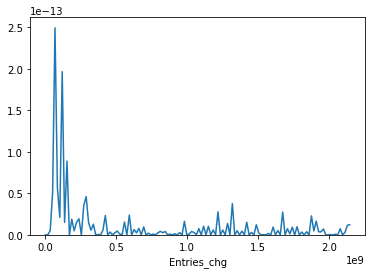

In [0]:
display(data.df[['Entries_chg','Exits_chg']].describe())
sns.distplot(data.df['Entries_chg'].dropna(),hist=False)


### Investigate Large Outliers
- Identify a turnstile outlier instance where `Entries_chg`> 10 million 
  - Turnstile `A010_R080_00-00-05` has an `Entries_chg` of 10,780,230 at `DateTime` 2016-07-15 16:00:00 

In [0]:
data.df[data.df['Entries_chg']>10000000].head()

C/A  Unit       SCP  ... Station_Linename   Entries_chg     Exits_chg
65766   A010  R080  00-00-05  ...   57 ST-7 AV_NQR  1.078023e+07  3.956347e+06
80929   A011  R080  01-00-04  ...   57 ST-7 AV_NQR  1.894869e+09  1.777224e+09
83326   A011  R080  01-00-05  ...   57 ST-7 AV_NQR  1.223349e+09  1.491761e+09
105487  A014  R081  02-06-01  ...        49 ST_NQR  5.037050e+07  1.325632e+09
127624  A016  R081  03-06-01  ...        49 ST_NQR  1.336544e+08  1.670737e+07

[5 rows x 17 columns]

### There are Turnstile Odometer Resets Which Cause Large Jumps in Interval Change Readings. 

Investigating Turnstile A010_R080_00-00-05, we find:
- The odometer value seems to have maxed-out around 10,782,157 at `DateTime` 2016-07-14 20:00:00 and the next recorded interval was 2016-07-15 16:00:00 with an odometer value of 1924, which computes as an `Entries_chg` of 10,780,233.
- To     

C/A  Unit       SCP  ... Station_Linename Entries_chg  Exits_chg
65760  A010  R080  00-00-05  ...   57 ST-7 AV_NQR       189.0       27.0
65761  A010  R080  00-00-05  ...   57 ST-7 AV_NQR        11.0        0.0
65762  A010  R080  00-00-05  ...   57 ST-7 AV_NQR        14.0      120.0
65763  A010  R080  00-00-05  ...   57 ST-7 AV_NQR       172.0      293.0
65764  A010  R080  00-00-05  ...   57 ST-7 AV_NQR       292.0      126.0
65765  A010  R080  00-00-05  ...   57 ST-7 AV_NQR       671.0      125.0
65766  A010  R080  00-00-05  ...   57 ST-7 AV_NQR  10780233.0  3956347.0
65767  A010  R080  00-00-05  ...   57 ST-7 AV_NQR       507.0      105.0

[8 rows x 17 columns]

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


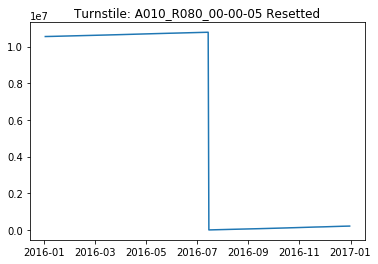

In [0]:
def investigate_turnstile(date0,date1,turnstile='A010_R080_00-00-05'):
    display(data.df[(data.df['Turnstile']==turnstile)
            &(data.df['Date']>=date0)
            &(data.df['Date']<=date1)])

    tmp = data.df[data.df['Turnstile']==turnstile]
    plt.plot(tmp['DateTime'],tmp['Entries'])
    plt.title('Turnstile: {} Resetted'.format(turnstile))

investigate_turnstile('07/14/16','07/15/2016',turnstile='A010_R080_00-00-05')

### Determine a Reasonable Turnstile Outlier Filter Value
To estimate a reasonable outlier value for a given turnstile, we can observe what an odometer interval change at a busy station (we'll use Times Square) looks like, and use the 97.5 percentile value as a proxy threshold for an outlier.

- `Station` TIMES SQ has a 97.5 percentile value of 1182 for an interval change, so we can, as a quick solution, assign and omit turnstile interval change values greater than 1250 as outliers. 

In [0]:
percents = [.5,.75,.875,.95,.975,.999]
def get_turnstile_quantiles(df,percents,feature='Entries_chg'):
    '''
    computes turnstile interval change quantiles
    df       : DataFrame
    percents : percenties to compute, list of floats
    feature  : feature to consider in percentiles, str
    returns  : None
    '''
    for p in percents:
        print('{} quantile({})=\t{:,.0f}'.format(feature,p,df['Entries_chg'].quantile(p)))

get_turnstile_quantiles(data.df[data.df['Station'].str.contains('TIMES SQ')],percents,feature='Entries_chg')        

Entries_chg quantile(0.5)=	154
Entries_chg quantile(0.75)=	404
Entries_chg quantile(0.875)=	673
Entries_chg quantile(0.95)=	959
Entries_chg quantile(0.975)=	1,182
Entries_chg quantile(0.999)=	9,797


### Clean Turnstile `Entries_chg`,`Exits_chg` Outliers
- The cleaned dataset appears bimodal:
 - `Entries_chg` on busy days are distrubuted with a mean around 6 million
 - `Entries_chg` on less buys days are distrubuted with a mean around 3 million
 - The bimodal shape appears to reflect patterns in weekday and weekend subway usage   

Data cleaning removed 177467 outliers (1.87)%


Entries         Exits   Entries_chg     Exits_chg
count  9.315203e+06  9.315203e+06  9.315203e+06  9.315203e+06
mean   3.478991e+07  2.789526e+07  1.640456e+02  1.227426e+02
std    1.932726e+08  1.730392e+08  2.212248e+02  1.859228e+02
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
25%    5.585215e+05  2.829570e+05  9.000000e+00  7.000000e+00
50%    2.559218e+06  1.481408e+06  7.100000e+01  4.800000e+01
75%    6.456531e+06  4.575503e+06  2.350000e+02  1.560000e+02
max    2.147480e+09  2.097170e+09  1.250000e+03  1.250000e+03

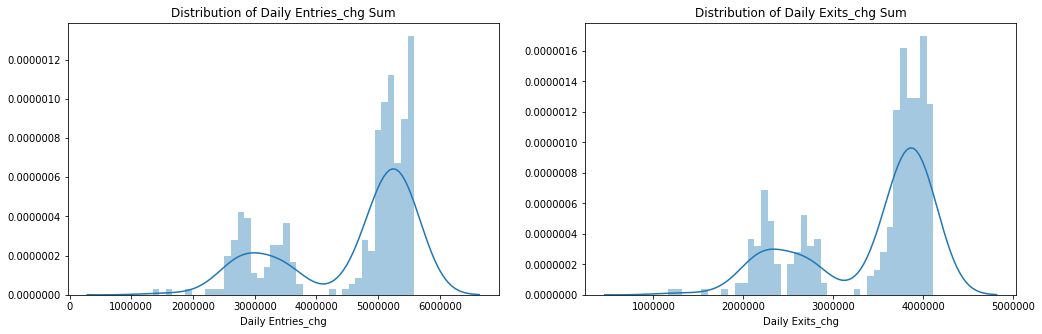

In [0]:
data.clean_outliers(max_interval_chg=1250,figsz=(17,5),bins=40)

### Process Feature Engineering based on Dates:
- Day of week `WeekDay` categorical
- US Federal holiday indicator `Holiday`
- `Season` categorical  


In [0]:
data.feature_eng()

day_interval runtime: 6.787119698524475 mins


In [0]:
display(data.df.head(4))
data.df.info()
data.df.describe()


C/A  Unit       SCP Station  ... Month WeekDay Season Holiday
1  A002  R051  02-00-00   59 ST  ...     1       6      0       0
2  A002  R051  02-00-00   59 ST  ...     1       6      0       0
3  A002  R051  02-00-00   59 ST  ...     1       6      0       0
4  A002  R051  02-00-00   59 ST  ...     1       6      0       0

[4 rows x 22 columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9315203 entries, 1 to 9492669
Data columns (total 22 columns):
C/A                 object
Unit                object
SCP                 object
Station             object
Line Name           object
Division            object
Date                object
Time                object
Description         object
Entries             int64
Exits               int64
DateTime            datetime64[ns]
Turnstile           object
Station_Division    object
Station_Linename    object
Entries_chg         float64
Exits_chg           float64
Hour                int64
Month               int64
WeekDay             int64
Season              int64
Holiday             int64
dtypes: datetime64[ns](1), float64(2), int64(7), object(12)
memory usage: 1.6+ GB


Entries         Exits  ...        Season       Holiday
count  9.315203e+06  9.315203e+06  ...  9.315203e+06  9.315203e+06
mean   3.478991e+07  2.789526e+07  ...  1.337048e+00  2.343739e-02
std    1.932726e+08  1.730392e+08  ...  1.206153e+00  1.512881e-01
min    0.000000e+00  0.000000e+00  ...  0.000000e+00  0.000000e+00
25%    5.585215e+05  2.829570e+05  ...  0.000000e+00  0.000000e+00
50%    2.559218e+06  1.481408e+06  ...  1.000000e+00  0.000000e+00
75%    6.456531e+06  4.575503e+06  ...  3.000000e+00  0.000000e+00
max    2.147480e+09  2.097170e+09  ...  3.000000e+00  1.000000e+00

[8 rows x 9 columns]

### Preview $X$ feature importances
 - utilize sklearn decision tree `feature_importances_` attribute
 - where a feature level of importance is its mean decrease in impurity for node splits within an ensemble of decision trees  
  - `WeekDay` shows the most promise in explaining variation in the data.


Feature Importance Summary:


importance
feature            
WeekDay    0.906359
Holiday    0.075521
Season     0.018120

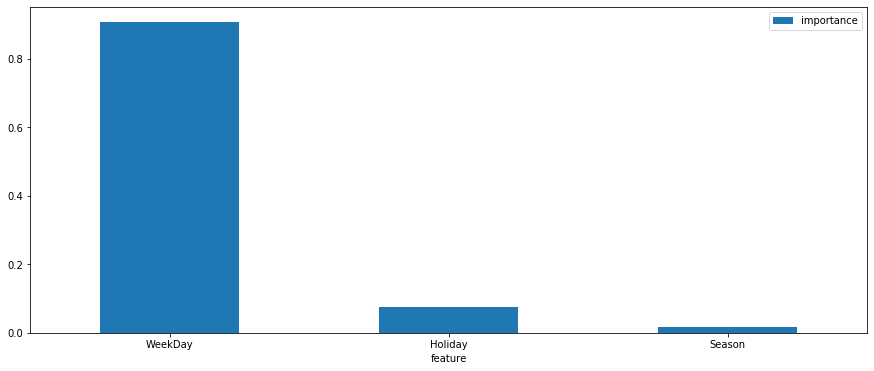

In [0]:
daily_aggs = {
              'Entries_chg':'sum',
              'WeekDay':'last',
              'Holiday':'last',
              'Season':'last',
             }
             
tmp =  data.df.groupby('Date',as_index=False).agg(daily_aggs)
tmp = tmp[tmp['Date']<'12/01/2016']
tmpX,tmpy = tmp.drop(['Date','Entries_chg'],axis=1), tmp['Entries_chg']
rf = RandomForestRegressor()
rf.fit(tmpX,tmpy)

Model.estimator_feature_importances(rf,tmpX,figsz=(15,6),xrotate=0,show_df=True)

### Create Daily Frequency Dataset with sum of `Entries_chg`
- Engineer new statistical features on target by `WorkDay` and `Season` to attempt to capture work business days and seasonality.  

In [0]:
daily_df = data.df.groupby('Date',as_index=False).agg(daily_aggs)

# compute target stats feature engineering 
for grp in ['WeekDay']:
    daily_df = data.target_eng(daily_df,grp=grp,target='Entries_chg')
daily_df   


Date  Entries_chg  ...  Entries_chg_WeekDay_max  Entries_chg_WeekDay_std
0    01/02/2016    2839003.0  ...                3691279.0            374997.129854
1    01/09/2016    3273771.0  ...                3691279.0            374997.129854
2    01/16/2016    3206714.0  ...                3691279.0            374997.129854
3    01/23/2016    1344768.0  ...                3691279.0            374997.129854
4    01/30/2016    3402993.0  ...                3691279.0            374997.129854
..          ...          ...  ...                      ...                      ...
331  11/25/2016    3537870.0  ...                5581837.0            342484.776556
332  12/02/2016    5453799.0  ...                5581837.0            342484.776556
333  12/09/2016    5469302.0  ...                5581837.0            342484.776556
334  12/23/2016    4949767.0  ...                5581837.0            342484.776556
335  12/30/2016    4740077.0  ...                5581837.0            342484.776556

[336 rows x 10 columns]

### Split Dataset into train and test sets

In [0]:
train,test = Data.split_data(daily_df,'01/01/2016','12/01/2016')

# separate into X features and y targets
Xtrain,ytrain = Data.compute_target_features(train,
                            Xdrop=['Date','Entries_chg'],target='Entries_chg')

Xtest,ytest = Data.compute_target_features(test,
                            Xdrop=['Date','Entries_chg'],target='Entries_chg')

display(train.head())
display(test.head(1))



Date  Entries_chg  ...  Entries_chg_WeekDay_max  Entries_chg_WeekDay_std
0  01/02/2016    2839003.0  ...                3691279.0            374997.129854
1  01/09/2016    3273771.0  ...                3691279.0            374997.129854
2  01/16/2016    3206714.0  ...                3691279.0            374997.129854
3  01/23/2016    1344768.0  ...                3691279.0            374997.129854
4  01/30/2016    3402993.0  ...                3691279.0            374997.129854

[5 rows x 10 columns]

Date  Entries_chg  ...  Entries_chg_WeekDay_max  Entries_chg_WeekDay_std
45  12/03/2016    3691279.0  ...                3691279.0            374997.129854

[1 rows x 10 columns]

### View Feature and Target Correlations 

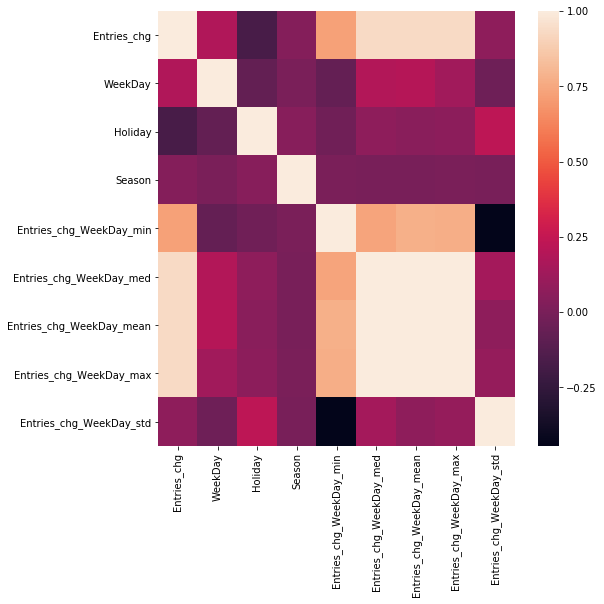

Target, Feature Correlations


Entries_chg
Entries_chg                  1.000000
Entries_chg_WeekDay_mean     0.935822
Entries_chg_WeekDay_med      0.933427
Entries_chg_WeekDay_max      0.932857
Entries_chg_WeekDay_min      0.724263
WeekDay                      0.184773
Entries_chg_WeekDay_std      0.071244
Season                       0.035787
Holiday                     -0.168630

In [0]:
Data.eda_corr(train)    

### `Weekday` feature exhibits a clear separation of subway ridership
- Weekends (0:Sunday, 6:Saturday) are centered around 3 million rides/day
- Work days (1:Monday, 2:Tuesday, 3:Wednesday, 4: Thursday, 5:Friday) are centered above 5 million rides/day  
- Monday holidays are centered closer to weekend daily ridership levels 

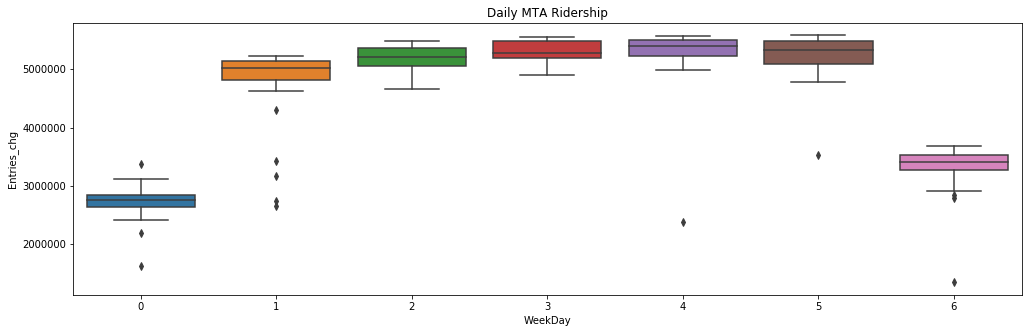

In [0]:
def eda_boxplot(df,x,y='Entries_chg',hue=None,figsz=(17,5),station=None):
    if station:
        df = df[df['Station_Linename']==station]
    fig,ax = plt.subplots(figsize=figsz)
    sns.boxplot(x=x,y=y,
                   hue=hue,
                   data=df)
    if station:
        ax.set(title='{} Daily Ridership'.format(station))
    else:
        ax.set(title='Daily MTA Ridership')    
    
eda_boxplot(train,'WeekDay',hue=None)

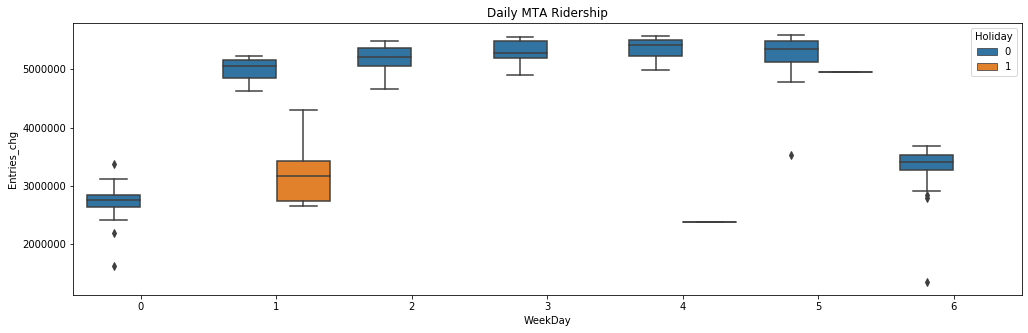

In [0]:
eda_boxplot(train,'WeekDay',hue='Holiday')

### Ridership by Season
- Summer (indicator value `2`) exhibits lower ridership than other seasons, which coincides with school break.
- Fall (season value `3`) has the busiest ridership (school back in session and NYers back from summer vacation)  


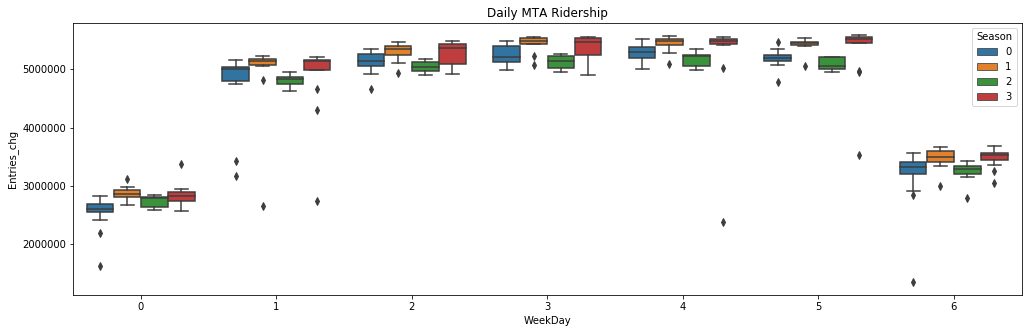

In [0]:
eda_boxplot(train,'WeekDay',hue='Season')

### Winter exhibits more similar ridership on weekdays and weekends
- Spring and Fall see the most ridership  
- Fall ridership during holidays had a wider range than winter and fall holidays

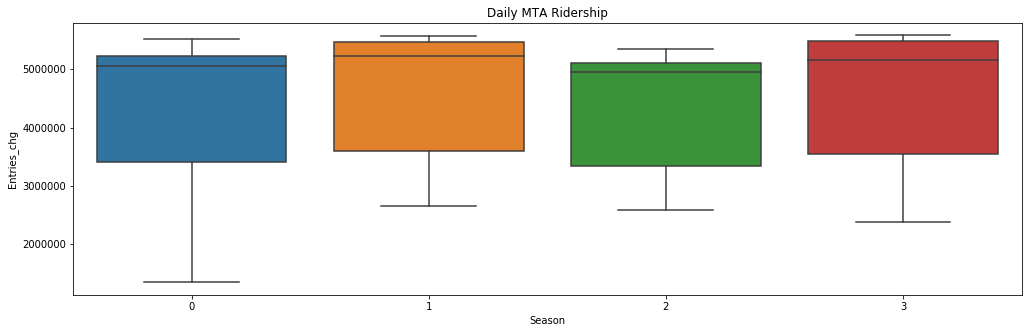

In [0]:
eda_boxplot(train,'Season',hue=None)

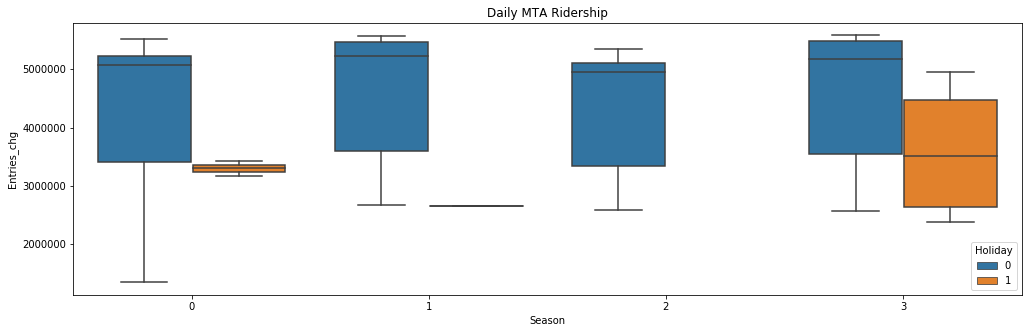

In [0]:
eda_boxplot(train,'Season',hue='Holiday')

### Question 1 

- Using January to November as a training set, we wish to step through every day in December, and using all data prior to that date, forecast the total number of entries on that day, [data source](https://data.ny.gov/Transportation/Turnstile-Usage-Data-2016/ekwu-khcy). 

- Ensure that you do whatever data cleaning and filtering is necessary. 

- What is the most appropriate metric for evaluating success?

### This data set has a continuous target variable, so we are working on a regression problem.
- An appropriate loss metric is root mean squared error $RMSE=\sqrt{\frac{1}{n}\Sigma_{i}^{n}(y_{i}-\hat{y}_{i})^{2}}$  



### init `model` object 

In [0]:
m = Model(Xtrain,ytrain,Xtest,ytest)

## Linear Regression as Baseline Estimator
- A linear regression for total daily ridership did reasonably well with a cross validated rmse around `300,000`. 

In [0]:
reg = LinearRegression()
r2_arr = cross_val_score(reg,
                         Xtrain,ytrain,
                         cv=m.folds,
                         scoring='neg_mean_squared_error')
cv_mse = np.mean(-1*r2_arr)
cv_rmse = np.sqrt(cv_mse)
print('linear regression rmse: {:,.0f}'.format(cv_rmse))


linear regression rmse: 304,039


## RandomForestRegressor
- The ensemble tree bagging model random forest underperformed linear regression when starting out with a wide range in randomized hyperparameters.  
- With a few rounds of random forest hyperparameters tuning, we were able to obtain rmse just below the rmse level obtained from linear regression.


### RandomizedSearchCV for RandomForestRegressor Hyperprameters
First cast a wide search of hyperparameters:

In [0]:
rf = RandomForestRegressor()
rf_tuned = m.model_selection(rf,{
                                'n_estimators':randint(1,100), # number bagged trees
                                'max_depth':randint(2,100), # max depth of tree 
                                'min_samples_split':randint(2,100), # min samples req'd to split node  
                                'min_samples_leaf':randint(1,100), # min samples req'd at a node  
                                'max_features':uniform(.2,.9), # features considered in node split  
                                'min_impurity_decrease':uniform(0,.1), # node is split if decreases impurity by this amt  
                                },
                             m.folds,
                             iters=100,
                             seed=0)
print('CV best_params_:',rf_tuned.best_params_)
print('CV best_score_:',rf_tuned.best_score_)

rmse: 334,566

CV best_params_: {'max_depth': 14, 'max_features': 0.994573998239412, 'min_impurity_decrease': 0.025062272019388543, 'min_samples_leaf': 1, 'min_samples_split': 41, 'n_estimators': 25}
CV best_score_: -111934715566.94296


RF tuning iteration 1: 

In [0]:
rf = RandomForestRegressor()
rf_tuned = m.model_selection(rf,{
                              'n_estimators':randint(10,100), # number bagged trees
                              'max_depth':randint(2,70), # max depth of tree 
                              'min_samples_split':randint(20,60), # min samples req'd to split node  
                              'min_samples_leaf':randint(1,20), # min samples req'd at a node  
                              'max_features':uniform(.5,1), # features considered in node split  
                              'min_impurity_decrease':uniform(.001,.09), # node is split if decreases impurity by this amt  
                              },
                             m.folds,
                             iters=100,
                             seed=0)
print('CV best_params_:',rf_tuned.best_params_)
print('CV best_score_:',rf_tuned.best_score_)

rmse: 308,824

CV best_params_: {'max_depth': 9, 'max_features': 0.9246854687515063, 'min_impurity_decrease': 0.0346752982300803, 'min_samples_leaf': 1, 'min_samples_split': 28, 'n_estimators': 89}
CV best_score_: -95372291822.90865


RF tuning iteration 2: 

In [0]:
rf = RandomForestRegressor()
rf_tuned = m.model_selection(rf,{
                              'n_estimators':randint(50,100), # number bagged trees
                              'max_depth':randint(2,30), # max depth of tree 
                              'min_samples_split':randint(10,50), # min samples req'd to split node  
                              'min_samples_leaf':randint(1,15), # min samples req'd at a node  
                              'max_features':uniform(.6,1), # features considered in node split  
                              'min_impurity_decrease':uniform(.01,.06), # node is split if decreases impurity by this amt  
                              },
                             m.folds,
                             iters=100,
                             seed=0)
print('CV best_params_:',rf_tuned.best_params_)
print('CV best_score_:',rf_tuned.best_score_)

rmse: 301,160

CV best_params_: {'max_depth': 12, 'max_features': 1.0908186128508779, 'min_impurity_decrease': 0.038169898175672505, 'min_samples_leaf': 1, 'min_samples_split': 29, 'n_estimators': 76}
CV best_score_: -90697318381.61478


RF tuning iteration 3: 

In [0]:
rf = RandomForestRegressor()
rf_tuned = m.model_selection(rf,{
                              'n_estimators':randint(40,95), # number bagged trees
                              'max_depth':randint(10,40), # max depth of tree 
                              'min_samples_split':randint(10,40), # min samples req'd to split node  
                              'min_samples_leaf':randint(1,4), # min samples req'd at a node  
                              'max_features':uniform(.7,1), # features considered in node split  
                              'min_impurity_decrease':uniform(.02,.08), # node is split if decreases impurity by this amt  
                              },
                             m.folds,
                             iters=100,
                             seed=0)
print('CV best_params_:',rf_tuned.best_params_)
print('CV best_score_:',rf_tuned.best_score_)

rmse: 303,072

CV best_params_: {'max_depth': 30, 'max_features': 0.9378928213745086, 'min_impurity_decrease': 0.0947371198339835, 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 90}
CV best_score_: -91852378249.06367


RF tuning iteration 4:

In [0]:
rf = RandomForestRegressor()
rf_tuned = m.model_selection(rf,{
                              'n_estimators':randint(60,110), # number bagged trees
                              'max_depth':[None], # max depth of tree 
                              'min_samples_split':randint(15,45), # min samples req'd to split node  
                              'min_samples_leaf':randint(1,2), # min samples req'd at a node  
                              'max_features':uniform(.725,1), # features considered in node split  
                              'min_impurity_decrease':uniform(.0175,.06), # node is split if decreases impurity by this amt  
                              },
                             m.folds,
                             iters=100,
                             seed=0)
print('CV best_params_:',rf_tuned.best_params_)
print('CV best_score_:',rf_tuned.best_score_)

rmse: 302,303

CV best_params_: {'max_depth': None, 'max_features': 1.0982907507832547, 'min_impurity_decrease': 0.042704522187436644, 'min_samples_leaf': 1, 'min_samples_split': 33, 'n_estimators': 104}
CV best_score_: -91386955797.99896


## GradientBoostingRegressor
- GradientBoosting eventually outperformed RandomForest in the end with rmse around 290,000

In [0]:
gb = GradientBoostingRegressor()
gb_tuned = m.model_selection(gb,{
                                  'learning_rate':uniform(.01,.99), # tree contribution shrinkage 
                                  'n_estimators':randint(100,900), # number boosting stages
                                  'max_depth':randint(2,100), # max depth of tree 
                                  'subsample':uniform(.1,.8), # frac of samples used to fit indiv base learners
                                  'min_samples_split':randint(2,100), # min samples req'd to split node  
                                  'min_samples_leaf':randint(1,100), # min samples req'd at a node  
                                  'min_weight_fraction_leaf':uniform(0,.1), # min wtd frac of total sum of wts req'd at leaf node  
                                  'min_impurity_decrease':uniform(0,.1), # node is split if decreases impurity by this amt  
                                  'max_features':uniform(.2,.9), # features considered in node split  
                                  'max_leaf_nodes':randint(1,100), # min samples req'd at a node  
                              },
                             m.folds,
                             iters=100,
                             seed=0)
print('CV best_params_:',gb_tuned.best_params_)
print('CV best_score_:',gb_tuned.best_score_)

rmse: 382,707

CV best_params_: {'learning_rate': 0.14386599167139755, 'max_depth': 38, 'max_features': 0.7558719473682893, 'max_leaf_nodes': 39, 'min_impurity_decrease': 0.022232138825158766, 'min_samples_leaf': 18, 'min_samples_split': 81, 'min_weight_fraction_leaf': 0.09025984755294048, 'n_estimators': 142, 'subsample': 0.3876063204590289}
CV best_score_: -146464618431.01822


GB tuning iteration 1:

In [0]:
gb = GradientBoostingRegressor()
gb_tuned = m.model_selection(gb,{
                                  'learning_rate':uniform(.01,.4), # tree contribution shrinkage 
                                  'n_estimators':randint(200,800), # number boosting stages
                                  'max_depth':randint(2,80), # max depth of tree 
                                  'subsample':uniform(.2,.8), # frac of samples used to fit indiv base learners
                                  'min_samples_split':randint(10,60), # min samples req'd to split node  
                                  'min_samples_leaf':randint(0,10), # min samples req'd at a node  
                                  'min_weight_fraction_leaf':uniform(0,.04), # min wtd frac of total sum of wts req'd at leaf node  
                                  'min_impurity_decrease':uniform(0,.05), # node is split if decreases impurity by this amt  
                                  'max_features':uniform(.2,1), # features considered in node split  
                                  'max_leaf_nodes':[None], # min samples req'd at a node  
                              },
                             m.folds,
                             iters=100,
                             seed=0)
print('CV best_params_:',gb_tuned.best_params_)
print('CV best_score_:',gb_tuned.best_score_)

rmse: 297,379

CV best_params_: {'learning_rate': 0.02298611826050551, 'max_depth': 56, 'max_features': 0.45319119372285194, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.006552761560762888, 'min_samples_leaf': 1, 'min_samples_split': 45, 'min_weight_fraction_leaf': 0.004619371885549923, 'n_estimators': 450, 'subsample': 0.3957211314097417}
CV best_score_: -88434183892.75401


GB tuning iteration 2:

In [0]:
gb = GradientBoostingRegressor()
gb_tuned = m.model_selection(gb,{
                                  'learning_rate':uniform(.001,.1), # tree contribution shrinkage 
                                  'n_estimators':randint(250,650), # number boosting stages
                                  'max_depth':randint(15,80), # max depth of tree 
                                  'subsample':uniform(.15,.7), # frac of samples used to fit indiv base learners
                                  'min_samples_split':randint(15,60), # min samples req'd to split node  
                                  'min_samples_leaf':randint(0,2), # min samples req'd at a node  
                                  'min_weight_fraction_leaf':uniform(0,.02), # min wtd frac of total sum of wts req'd at leaf node  
                                  'min_impurity_decrease':uniform(0,.05), # node is split if decreases impurity by this amt  
                                  'max_features':uniform(.2,.9), # features considered in node split  
                                  'max_leaf_nodes':[None], # min samples req'd at a node  
                              },
                             m.folds,
                             iters=100,
                             seed=0)
print('CV best_params_:',gb_tuned.best_params_)
print('CV best_score_:',gb_tuned.best_score_)

rmse: 289,651

CV best_params_: {'learning_rate': 0.06316928996348438, 'max_depth': 18, 'max_features': 0.30882742502522065, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.03403486193340174, 'min_samples_leaf': 1, 'min_samples_split': 35, 'min_weight_fraction_leaf': 0.0008595281719837788, 'n_estimators': 505, 'subsample': 0.17522367219999863}
CV best_score_: -83897631114.86343


GB tuning iteration 3: 

In [0]:
gb = GradientBoostingRegressor()
gb_tuned = m.model_selection(gb,{
                                  'learning_rate':uniform(.015,.09), # tree contribution shrinkage 
                                  'n_estimators':randint(200,650), # number boosting stages
                                  'max_depth':randint(10,80), # max depth of tree 
                                  'subsample':uniform(.15,.6), # frac of samples used to fit indiv base learners
                                  'min_samples_split':randint(20,70), # min samples req'd to split node  
                                  'min_samples_leaf':randint(0,2), # min samples req'd at a node  
                                  'min_weight_fraction_leaf':uniform(0,.02), # min wtd frac of total sum of wts req'd at leaf node  
                                  'min_impurity_decrease':uniform(0,.01), # node is split if decreases impurity by this amt  
                                  'max_features':uniform(.5,.9), # features considered in node split  
                                  'max_leaf_nodes':[None], # min samples req'd at a node  
                              },
                             m.folds,
                             iters=100,
                             seed=0)
print('CV best_params_:',gb_tuned.best_params_)
print('CV best_score_:',gb_tuned.best_score_)

rmse: 279,087

CV best_params_: {'learning_rate': 0.07095236096713593, 'max_depth': 13, 'max_features': 0.6088274250252206, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.006806972386680347, 'min_samples_leaf': 1, 'min_samples_split': 40, 'min_weight_fraction_leaf': 0.0008595281719837788, 'n_estimators': 455, 'subsample': 0.1716202904571417}
CV best_score_: -77889671452.07893


GB tuning iteration 4:

In [0]:
gb = GradientBoostingRegressor()
gb_tuned = m.model_selection(gb,{
                                  'learning_rate':uniform(.065,.1), # tree contribution shrinkage 
                                  'n_estimators':randint(175,300), # number boosting stages
                                  'max_depth':randint(50,75), # max depth of tree 
                                  'subsample':uniform(.1,.4), # frac of samples used to fit indiv base learners
                                  'min_samples_split':randint(30,80), # min samples req'd to split node  
                                  'min_samples_leaf':randint(0,2), # min samples req'd at a node  
                                  'min_weight_fraction_leaf':uniform(0,.019), # min wtd frac of total sum of wts req'd at leaf node  
                                  'min_impurity_decrease':uniform(0,.01), # node is split if decreases impurity by this amt  
                                  'max_features':uniform(.6,.93), # features considered in node split  
                                  'max_leaf_nodes':[None], # min samples req'd at a node  
                              },
                             m.folds,
                             iters=100,
                             seed=0)
print('CV best_params_:',gb_tuned.best_params_)
print('CV best_score_:',gb_tuned.best_score_)

rmse: 283,769

CV best_params_: {'learning_rate': 0.09212520767618641, 'max_depth': 71, 'max_features': 0.8187944448875284, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0005887028330105148, 'min_samples_leaf': 1, 'min_samples_split': 67, 'min_weight_fraction_leaf': 0.01627834969432332, 'n_estimators': 260, 'subsample': 0.35567475969015705}
CV best_score_: -80524889834.036


### Determine Cross-Validated Tuned Estimator Scores, Summarize Results, and Predict Unseen December Ridership
- Cross validate tuned `RandomForestRegressor` and `GradientBoostingRegressor`
- The most important feature in the data set were the `Entries_chg_WeekDay_min`,`Entries_chg_WeekDay_med`, and `Holiday`, which seems to reflect that the `min` features helped the estimator become more flexible in predicting lower bounds.
- Final Test RMSE was `355,000` vs. `283,000` Train RMSE         


[ 0.41168471  0.90314293 -0.0635916  -0.1563871   0.36846284]
[ 0.46859044  0.93463359 -0.09357173 -0.03513243  0.39272326]

Linear Estimator Cross-Validated Loss Summary:

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=1.0982907507832547,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.042704522187436644,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=33, min_weight_fraction_leaf=0.0,
                      n_estimators=104, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
5-fold CV RMSE: 312,574

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.09212520767618641,
                          loss='ls', max_depth=71,
                          max_features=0.81879444488

importance
feature                             
Entries_chg_WeekDay_min     0.366099
Entries_chg_WeekDay_max     0.167451
Holiday                     0.163465
Entries_chg_WeekDay_mean    0.110715
Entries_chg_WeekDay_med     0.096928
WeekDay                     0.050906
Season                      0.032409
Entries_chg_WeekDay_std     0.012026

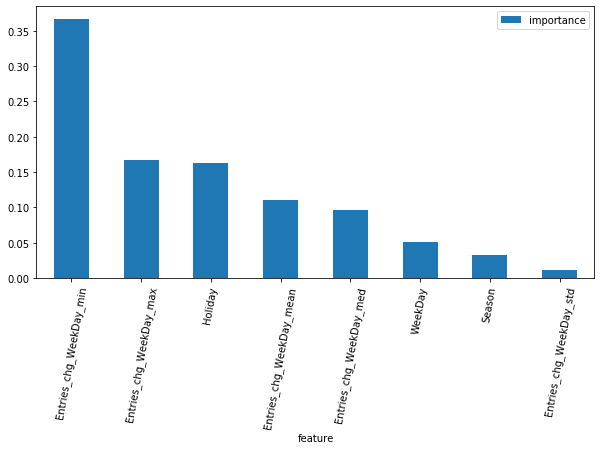

----------------------------------------------------------------------
Test results:

Test R2: 0.893
Test RMSE: 362,670


In [0]:
m.add_estimator(rf_tuned.best_estimator_)
m.add_estimator(gb_tuned.best_estimator_)

for estimator in m.estimator_list:
    m.cv_train(estimator,
               Xtrain,ytrain,
               cv=m.folds)

m.summarize_estimators()

m.best_estimator = m.select_best_estimator()  

m.compute_feature_importances(xrotate=80)

# fit best estimator and predict ridership on unseen Xtest
m.fit_predict_best_estimator(Xtrain,ytrain,Xtest,ytest) 


## Question 2 
- Similar to 1, forecast turnstile entries for every station individually for every day in December. 
- Is this problem easier or harder than forecasting for the system as a whole?

#### Reasons this task is more difficult:
1. Requires more complexity as each `Station_Linename` must be separated from the main daily frequency dataset and trained individually.
2. Each `Station_Linename` behaves differently (e.g. slower weekends at TIMES SQ vs. busier weekends at AQUEDUCT) so one-size-fits-all estimator would be inappropriate. 
3. Hyperparameter tuning for every station will be time consuming work. 
4. It will be difficult to train on January - November data, and then hope that the fit will generalize to December if there are specific activities that occur outside or only in December at specific locations in NYC (e.g. Halloween Day, Thanksgiving Parades, NY Marathon, New Years Eve).    

### Create New Dataset by `Date` and `Station_LineName` 

In [0]:
station_df = data.df.groupby(['Date','Station_Linename'],
                             as_index=False).agg(daily_aggs)

station_df.sort_values(['Date','Station_Linename']) 

display(station_df.head(4))
station_df.describe()

Date Station_Linename  Entries_chg  WeekDay  Holiday  Season
0  01/02/2016           1 AV_L      14425.0        6        0       0
1  01/02/2016  103 ST-CORONA_7       8843.0        6        0       0
2  01/02/2016         103 ST_1       7932.0        6        0       0
3  01/02/2016         103 ST_6       5664.0        6        0       0

Entries_chg        WeekDay        Holiday         Season
count  157876.000000  157876.000000  157876.000000  157876.000000
mean     9679.231295       2.998841       0.023797       1.369651
std     10275.044980       2.000464       0.152417       1.202970
min         0.000000       0.000000       0.000000       0.000000
25%      3586.000000       1.000000       0.000000       0.000000
50%      6629.000000       3.000000       0.000000       1.000000
75%     11991.250000       5.000000       0.000000       3.000000
max    106197.000000       6.000000       1.000000       3.000000

### There are reduntant and incorrect `Station_Linename` in the dateset
When performing `groupby` on `Station_Linename`, I found redundancies in names of `Station_Linenames`, e.g.:
- `BOROUGH HALL_2345R` and `BOROUGH HALL_R2345` (same station and linename, but reversed order)
- `BROADWAY_NQ`, `BROADWAY_NQW` and `TIMES SQ-42 ST_1237ACENQRS`, 
`TIMES SQ-42 ST_1237ACENQRSW` (mta added W train to the `Linename` during the year)
- There is no `G` train at 42 Street Port Authority, so this seems to be a typo of `G` rather than `Q` in `42 ST-PORT AUTH_ACENGRS1237`.

### We can address this issue by replacing redundant and erroneous `Station_Linename` with values in `Data.stations_d`

In [0]:
stations_list = sorted(list(set(data.df['Station_Linename'])))
stations_list

['1 AV_L',
 '103 ST-CORONA_7',
 '103 ST_1',
 '103 ST_6',
 '103 ST_BC',
 '104 ST_A',
 '104 ST_JZ',
 '110 ST_6',
 '111 ST_7',
 '111 ST_A',
 '111 ST_J',
 '116 ST-COLUMBIA_1',
 '116 ST_23',
 '116 ST_6',
 '116 ST_BC',
 '121 ST_JZ',
 '125 ST_1',
 '125 ST_23',
 '125 ST_456',
 '125 ST_ACBD',
 '135 ST_23',
 '135 ST_BC',
 '137 ST CITY COL_1',
 '138/GRAND CONC_45',
 '14 ST-UNION SQ_456LNQR',
 '14 ST-UNION SQ_456LNQRW',
 '14 ST-UNION SQ_LNQR456',
 '14 ST-UNION SQ_LNQR456W',
 '14 ST_123FLM',
 '14 ST_ACEL',
 '14 ST_FLM123',
 '145 ST_1',
 '145 ST_3',
 '145 ST_ABCD',
 '149/GRAND CONC_245',
 '14TH STREET_1',
 '15 ST-PROSPECT_FG',
 '155 ST_BD',
 '155 ST_C',
 '157 ST_1',
 '161/YANKEE STAD_4BD',
 '161/YANKEE STAD_BD4',
 '163 ST-AMSTERDM_C',
 '167 ST_4',
 '167 ST_BD',
 '168 ST_1AC',
 '168 ST_AC1',
 '169 ST_F',
 '170 ST_4',
 '170 ST_BD',
 '174 ST_25',
 '174-175 STS_BD',
 '175 ST_A',
 '176 ST_4',
 '18 AV_D',
 '18 AV_F',
 '18 AV_N',
 '18 ST_1',
 '181 ST_1',
 '181 ST_A',
 '182-183 STS_BD',
 '183 ST_4',
 '190 S

### Compute individual DataFrames by `Station_Linename` and store to `stations_train_test_dict` container
 - clean `Station_Linename` values
 - save individual train, test sets  

In [0]:
# clean redundant and incorrect Station_Linename values
clean_station_df = data.clean_stationLinenames(station_df)

# store by-station train, test datasets in data.stations_train_test_dict 
stations_train_test_dict = Data.store_station_datasets(clean_station_df,
                                                       data.stations_name_list,
                                                       date0='01/01/2016',
                                                       date1='12/01/2016',
                                                       tgt_eng_grps=['WeekDay'])
station_df.head()

Station_Linename individual train, test datasets computed


Date Station_Linename  Entries_chg  WeekDay  Holiday  Season
0  01/02/2016           1 AV_L      14425.0        6        0       0
1  01/02/2016  103 ST-CORONA_7       8843.0        6        0       0
2  01/02/2016         103 ST_1       7932.0        6        0       0
3  01/02/2016         103 ST_6       5664.0        6        0       0
4  01/02/2016        103 ST_BC       2286.0        6        0       0

### There are `Station_Linenames` with missing daily data
 - e.g. `CITY HALL_R` is missing rows in train and no data whatsoever in December 2016 for test

In [0]:
# CITY HALL_R
display(stations_train_test_dict['CITY HALL_R'][0].head())
stations_train_test_dict['CITY HALL_R'][1]

Date  ... Entries_chg_WeekDay_std
0  01/02/2016  ...              902.539915
1  01/09/2016  ...              902.539915
2  01/16/2016  ...              902.539915
3  01/23/2016  ...              902.539915
4  01/30/2016  ...              902.539915

[5 rows x 11 columns]

Empty DataFrame
Columns: [Date, Station_Linename, Entries_chg, WeekDay, Holiday, Season, Entries_chg_WeekDay_min, Entries_chg_WeekDay_med, Entries_chg_WeekDay_mean, Entries_chg_WeekDay_max, Entries_chg_WeekDay_std]
Index: []

In [0]:
# separate data to check train data distributions
train_station,test_station = Data.split_data(station_df,'01/01/2016','12/01/2016')
display(train_station.head())
display(test_station.head(1))


Date Station_Linename  Entries_chg  WeekDay  Holiday  Season
0  01/02/2016           1 AV_L      14425.0        6        0       0
1  01/02/2016  103 ST-CORONA_7       8843.0        6        0       0
2  01/02/2016         103 ST_1       7932.0        6        0       0
3  01/02/2016         103 ST_6       5664.0        6        0       0
4  01/02/2016        103 ST_BC       2286.0        6        0       0

Date Station_Linename  Entries_chg  WeekDay  Holiday  Season
147097  12/01/2016           1 AV_L      18866.0        4        0       0

### A very active station such as TIMES SQUARE exhibits a more typical ridership distribution by `WeekDay`  

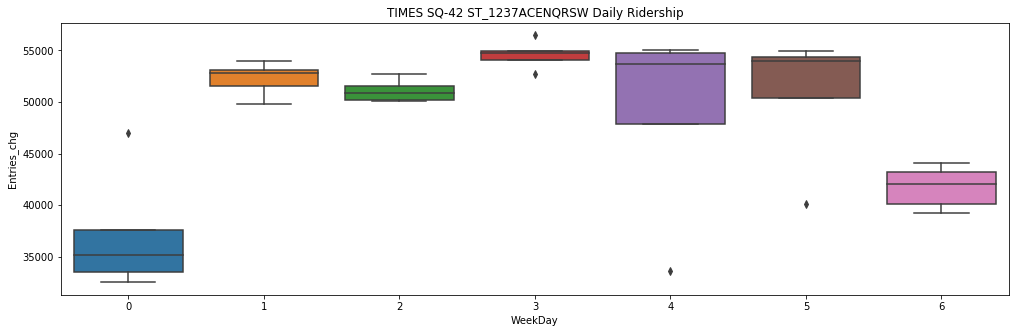

In [0]:
eda_boxplot(train_station,'WeekDay',hue=None,station='TIMES SQ-42 ST_1237ACENQRSW')

### An inactive and special-use station such as AQUEDUCT RACETRACK exhibits an atypical ridership distribution by `WeekDay` (busier on weekends)

- This station will benefit from its own estimator fit instead of a shared, general fit.

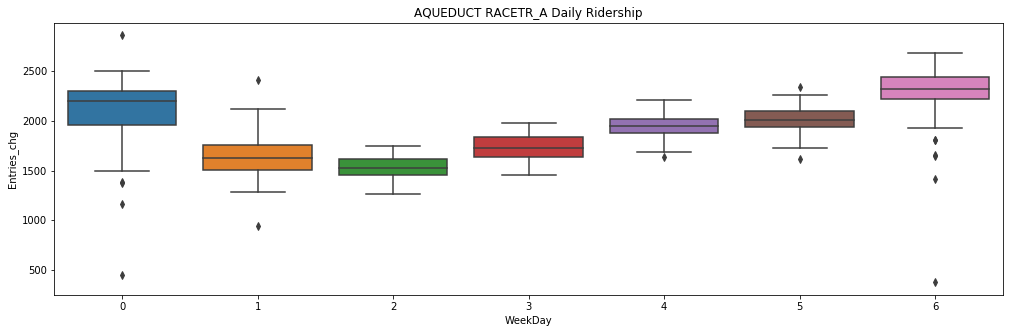

In [0]:
eda_boxplot(train_station,'WeekDay',hue=None,station='AQUEDUCT RACETR_A')

### Probem 2: Train all individual `Station_Linenames` and store metrics `rmse`,`r2` and model `best_est` to  container `station_results_d`
- To demonstrate the gist of a solution to this problem, the algo is run with  default sklearn estimator hyperparamers for each `Station_Linename`. 
- Although the algo is capable of running with `RandomizedSearchCV`, the training costs would be very expensive.     

In [0]:
gb_params = {'learning_rate':uniform(.01,.06),
             'n_estimators':randint(500,1000),
             'max_depth':randint(20,80),
            }

gb_params = {}            
# store stations estimator metrics 
station_results_d = Model.estimate_stations(stations_train_test_dict,
                                            GradientBoostingRegressor(),
                                            param_dists=gb_params,iters=1,
                                            target='Entries_chg')
station_results_d  

Training with default sklearn estimator hyperparameters:
Missing test data for CITY HALL_R
Missing test data for CORTLANDT ST_R
Missing test data for JUNIUS ST_3
Missing test data for ORCHARD BEACH_6
Missing test data for PATH NEW WTC_1
Missing test data for PATH WTC 2_1
Missing test data for PENNSYLVANIA AV_3
Missing test data for SUTTER AV-RUTLD_3
Total Runtime: 0.38


defaultdict(tuple,
            {'1 AV_L': [3191.386650988462,
              -0.1129656793170204,
              GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                                        init=None, learning_rate=0.1, loss='ls', max_depth=3,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0, min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0, n_estimators=100,
                                        n_iter_no_change=None, presort='deprecated',
                                        random_state=None, subsample=1.0, tol=0.0001,
                                        validation_fraction=0.1, verbose=0, warm_start=False)],
             '103 ST-CORONA_7': [1774.5822239250756,
              0.6388280621617193,
              Gradient

----------------------------------------------------------------------
Individual Station Test Results:


sum Test RMSE:	768,331



RMSE          R2
count    457.000000  457.000000
mean    1681.249225    0.618462
std     2387.499425    0.277185
min       65.500352    0.000000
25%      587.087184    0.507025
50%     1058.606419    0.715612
75%     1872.561554    0.830184
max    26234.304965    0.948678

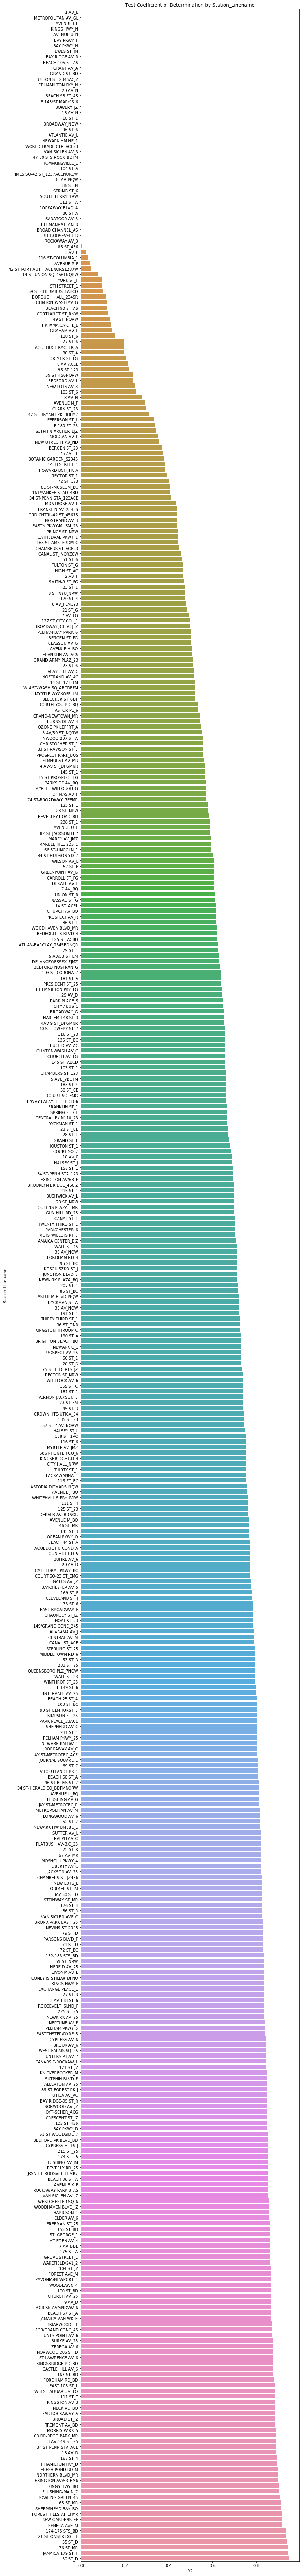

In [0]:
Model.station_estimator_results(station_results_d)


## Question 3
- Augment your solution to 2. With whatever external data (one or two sources) you think is most appropriate. 
- Explain why you think this data would be useful in predicting ridership and the improvement in predictive accuracy

### Data Augmentation Ideas
 - Add NYC public school in-session indicator (source: [NYC Dept Ed](https://www.schools.nyc.gov/docs/default-source/default-document-library/2016-17-school-year-calendar)) to introduce seasonal effects on ridership.
 - Add indicators for NYC basketball, hockey, baseball NYC home games (source: [Sports Reference](https://www.sports-reference.com/)) to provide information on behavior around sporting events (e.g. ridership will increase system wide during baseball season compared to the off-season as spectators take the subway to and from the event).  
 - Add weather conditions by day of year to introduce behavior around weather extremes (source: [Kaggle](https://www.kaggle.com/mathijs/weather-data-in-new-york-city-2016)).
   

### Process NYC sporting events and school in-session indicators

In [0]:
root_dir = "/content/gdrive/My Drive/"
events_fname = 'nyc_events.csv'

dt_parser = lambda x: pd.to_datetime(x) 
events_raw_df = pd.read_csv(data.cwd+events_fname,
                            parse_dates=['Date'],date_parser=dt_parser)
events_raw_df.info()
events_raw_df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 14 columns):
Date                  366 non-null datetime64[ns]
Weekend               105 non-null object
WeekDay               366 non-null int64
SchoolDay             366 non-null int64
School Holiday        366 non-null int64
New York Rangers      366 non-null int64
Brooklyn Nets         366 non-null int64
New York Knicks       366 non-null int64
New York Islanders    366 non-null int64
New York Mets         366 non-null int64
New York Yankees      366 non-null int64
New York Giants       366 non-null int64
New York Jets         366 non-null int64
US Open               366 non-null int64
dtypes: datetime64[ns](1), int64(12), object(1)
memory usage: 40.2+ KB


Date  Weekend  WeekDay  ...  New York Giants  New York Jets  US Open
361 2016-12-27      NaN        3  ...                0              0        0
362 2016-12-28      NaN        4  ...                0              0        0
363 2016-12-29      NaN        5  ...                0              0        0
364 2016-12-30      NaN        6  ...                0              0        0
365 2016-12-31  weekend        7  ...                0              0        0

[5 rows x 14 columns]

In [0]:
def process_nyc_events(inputdf,data_dict):
    '''
    obtain nyc school days and sporting events indicators
    and merge wwith original data in data_dict
    inputdf   : external NYC related events, DataFrame
    data_dict : original station data in data_dict, dict
    returns   : dict
    '''
    df = inputdf.drop(['Weekend','WeekDay','School Holiday'],axis=1)
    df['Date'] = df['Date'].apply(lambda x: x.strftime('%m/%d/%Y'))
    return df

events_df = process_nyc_events(events_raw_df,stations_train_test_dict)    
events_df.info()
events_df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 11 columns):
Date                  366 non-null object
SchoolDay             366 non-null int64
New York Rangers      366 non-null int64
Brooklyn Nets         366 non-null int64
New York Knicks       366 non-null int64
New York Islanders    366 non-null int64
New York Mets         366 non-null int64
New York Yankees      366 non-null int64
New York Giants       366 non-null int64
New York Jets         366 non-null int64
US Open               366 non-null int64
dtypes: int64(10), object(1)
memory usage: 31.6+ KB


Date  SchoolDay  ...  New York Jets  US Open
0    01/01/2016          0  ...              0        0
1    01/02/2016          0  ...              0        0
2    01/03/2016          0  ...              0        0
3    01/04/2016          1  ...              0        0
4    01/05/2016          1  ...              0        0
..          ...        ...  ...            ...      ...
361  12/27/2016          0  ...              0        0
362  12/28/2016          0  ...              0        0
363  12/29/2016          0  ...              0        0
364  12/30/2016          0  ...              0        0
365  12/31/2016          0  ...              0        0

[366 rows x 11 columns]

### Merge NYC Events Dataset  

In [0]:
aug_df = pd.merge(clean_station_df,events_df,on='Date',how='left')

aug_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157876 entries, 0 to 157875
Data columns (total 16 columns):
Date                  157876 non-null object
Station_Linename      157876 non-null object
Entries_chg           157876 non-null float64
WeekDay               157876 non-null int64
Holiday               157876 non-null int64
Season                157876 non-null int64
SchoolDay             157876 non-null int64
New York Rangers      157876 non-null int64
Brooklyn Nets         157876 non-null int64
New York Knicks       157876 non-null int64
New York Islanders    157876 non-null int64
New York Mets         157876 non-null int64
New York Yankees      157876 non-null int64
New York Giants       157876 non-null int64
New York Jets         157876 non-null int64
US Open               157876 non-null int64
dtypes: float64(1), int64(13), object(2)
memory usage: 20.5+ MB


### Obtain NYC Weather Data:




In [0]:
root_dir = "/content/gdrive/My Drive/"
weather_fname = 'weatherNYC.csv'

dt_parser = lambda x: pd.to_datetime(x).strftime('%m/%d/%Y')
weather_raw_df = pd.read_csv(data.cwd+weather_fname,
                         parse_dates=['date'],date_parser=dt_parser)
weather_raw_df.info()
weather_raw_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
date                   366 non-null datetime64[ns]
maximum temperature    366 non-null int64
minimum temperature    366 non-null int64
average temperature    366 non-null float64
precipitation          366 non-null object
snow fall              366 non-null object
snow depth             366 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 20.1+ KB


date  maximum temperature  ...  snow fall  snow depth
0 2016-01-01                   42  ...          0           0
1 2016-01-02                   40  ...          0           0
2 2016-01-03                   45  ...          0           0
3 2016-01-04                   36  ...          0           0
4 2016-01-05                   29  ...          0           0

[5 rows x 7 columns]

### Process Features on Weather data
- filter required date range
- add `freezing` indicator 

In [0]:
def eng_weather_data(weather_data,target='Entries_chg',grp='Station_Linename',
                     date0='01/01/2016',date1='12/31/2016'):
    '''
    engineer features on weather data and merge with original dataset
    weather_df    : dataset to process, DataFrame
    target        : target name, str
    grp           : group by feature in target feature eng, str
    date0         : start date inclusive, str
    date1         : end date inclusive, str
    returns       : DataFrame, daily frequency
    '''
    df = weather_data.copy()
    rename_d = {'date':'Date',
                'maximum temperature':'maxTemp',
                'average temperature':'meanTemp',
                'minimum temperature':'minTemp',
                }
  
    df.rename(columns=rename_d,inplace=True)
    df['Date'] = df['Date'].apply(lambda x: x.strftime('%m/%d/%Y'))
    # specify dates
    df = df[(df['Date']>=date0)&(df['Date']<=date1)]
    # replace trace str values 'T' with numeric  1e-7
    for col in ['precipitation','snow fall','snow depth']:
        df[col].replace({'T':.0001},inplace=True)
        df[col] = df[col].astype(np.float)
    # add freezing indicator
    df['freezing'] = np.where(df['meanTemp']<=28,1,0)
    return df 

weather_df = eng_weather_data(weather_raw_df,
                              date0='01/01/2016',date1='12/31/2016')
weather_df.info()
display(weather_df.describe())
weather_df 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 8 columns):
Date             366 non-null object
maxTemp          366 non-null int64
minTemp          366 non-null int64
meanTemp         366 non-null float64
precipitation    366 non-null float64
snow fall        366 non-null float64
snow depth       366 non-null float64
freezing         366 non-null int64
dtypes: float64(4), int64(3), object(1)
memory usage: 25.7+ KB


maxTemp     minTemp    meanTemp  ...   snow fall  snow depth    freezing
count  366.000000  366.000000  366.000000  ...  366.000000  366.000000  366.000000
mean    64.625683   49.806011   57.215847  ...    0.098365    0.275958    0.046448
std     18.041787   16.570747   17.124760  ...    1.441630    1.928253    0.210742
min     15.000000   -1.000000    7.000000  ...    0.000000    0.000000    0.000000
25%     50.000000   37.250000   44.000000  ...    0.000000    0.000000    0.000000
50%     64.500000   48.000000   55.750000  ...    0.000000    0.000000    0.000000
75%     81.000000   65.000000   73.500000  ...    0.000000    0.000000    0.000000
max     96.000000   81.000000   88.500000  ...   27.300000   22.000000    1.000000

[8 rows x 7 columns]

Date  maxTemp  minTemp  ...  snow fall  snow depth  freezing
0    01/01/2016       42       34  ...     0.0000         0.0         0
1    01/02/2016       40       32  ...     0.0000         0.0         0
2    01/03/2016       45       35  ...     0.0000         0.0         0
3    01/04/2016       36       14  ...     0.0000         0.0         1
4    01/05/2016       29       11  ...     0.0000         0.0         1
..          ...      ...      ...  ...        ...         ...       ...
361  12/27/2016       60       40  ...     0.0000         0.0         0
362  12/28/2016       40       34  ...     0.0000         0.0         0
363  12/29/2016       46       33  ...     0.0000         0.0         0
364  12/30/2016       40       33  ...     0.0001         0.0         0
365  12/31/2016       44       31  ...     0.0000         0.0         0

[366 rows x 8 columns]

### Merge Weather Data with `aug_df`
- split train, test sets

In [0]:
# add weather
aug_df = pd.merge(aug_df,weather_df,on='Date',how='left')

# train, test split
aug_train,aug_test = Data.split_data(aug_df,'01/01/2016','12/01/2016')

display(aug_train.describe())
aug_train.info()
aug_train.head()


Entries_chg        WeekDay  ...     snow depth       freezing
count  147097.000000  147097.000000  ...  147097.000000  147097.000000
mean     9695.168759       2.989259  ...       0.312327       0.041483
std     10282.720173       2.002841  ...       2.073658       0.199405
min         0.000000       0.000000  ...       0.000000       0.000000
25%      3598.000000       1.000000  ...       0.000000       0.000000
50%      6646.000000       3.000000  ...       0.000000       0.000000
75%     12012.000000       5.000000  ...       0.000000       0.000000
max    106197.000000       6.000000  ...      22.000000       1.000000

[8 rows x 21 columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147097 entries, 0 to 147096
Data columns (total 23 columns):
Date                  147097 non-null object
Station_Linename      147097 non-null object
Entries_chg           147097 non-null float64
WeekDay               147097 non-null int64
Holiday               147097 non-null int64
Season                147097 non-null int64
SchoolDay             147097 non-null int64
New York Rangers      147097 non-null int64
Brooklyn Nets         147097 non-null int64
New York Knicks       147097 non-null int64
New York Islanders    147097 non-null int64
New York Mets         147097 non-null int64
New York Yankees      147097 non-null int64
New York Giants       147097 non-null int64
New York Jets         147097 non-null int64
US Open               147097 non-null int64
maxTemp               147097 non-null int64
minTemp               147097 non-null int64
meanTemp              147097 non-null float64
precipitation         147097 non-null float64
s

Date Station_Linename  Entries_chg  ...  snow fall  snow depth  freezing
0  01/02/2016           1 AV_L      14425.0  ...        0.0         0.0         0
1  01/02/2016  103 ST-CORONA_7       8843.0  ...        0.0         0.0         0
2  01/02/2016         103 ST_1       7932.0  ...        0.0         0.0         0
3  01/02/2016         103 ST_6       5664.0  ...        0.0         0.0         0
4  01/02/2016        103 ST_BC       2286.0  ...        0.0         0.0         0

[5 rows x 23 columns]

### View NYC Public School In-Session Effects on Ridership  

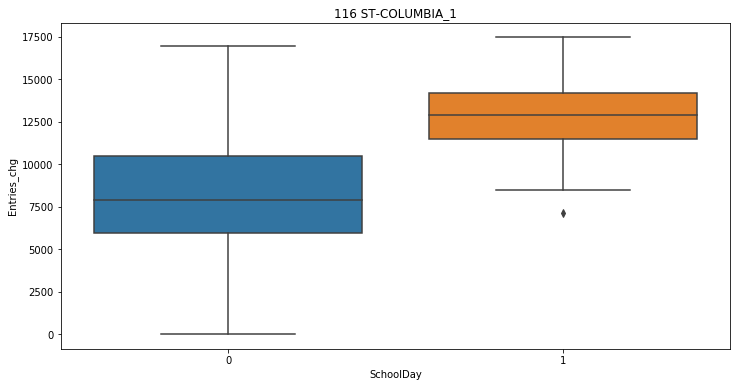

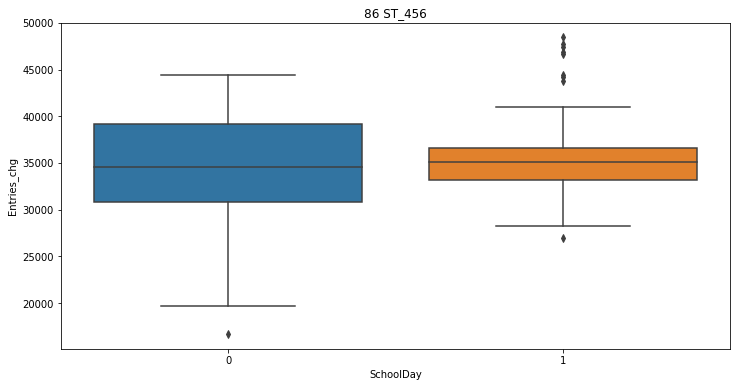

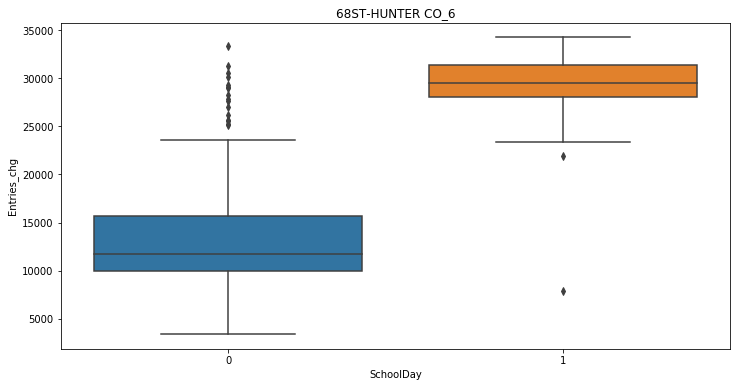

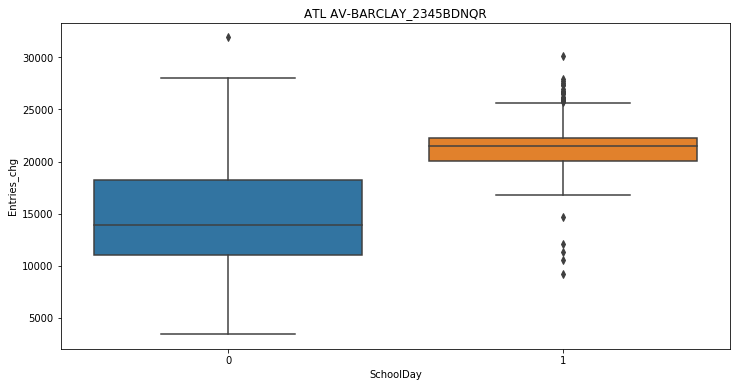

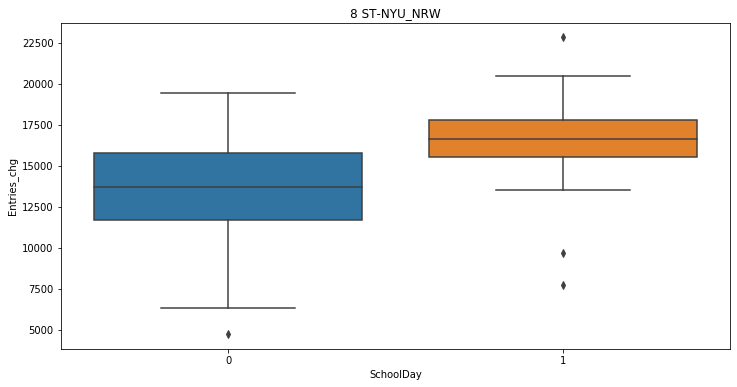

In [0]:
def viz_aug_data(df,figsz=(12,6),x='Season',
                 station='TIMES SQ-42 ST_ACENQRS1237',hue=None):
    fig,ax = plt.subplots(figsize=(12,6))
    station_df = df[df['Station_Linename']==station]
    sns.boxplot(x=x,y='Entries_chg',hue=hue,data=station_df)
    ax.set(title='{}'.format(stn))

for stn in  [
             '116 ST-COLUMBIA_1',
             '86 ST_456',
             '68ST-HUNTER CO_6',
             'ATL AV-BARCLAY_2345BDNQR',
             '8 ST-NYU_NRW']:	
    viz_aug_data(aug_train,figsz=(12,6),x='SchoolDay',station=stn,hue=None)    

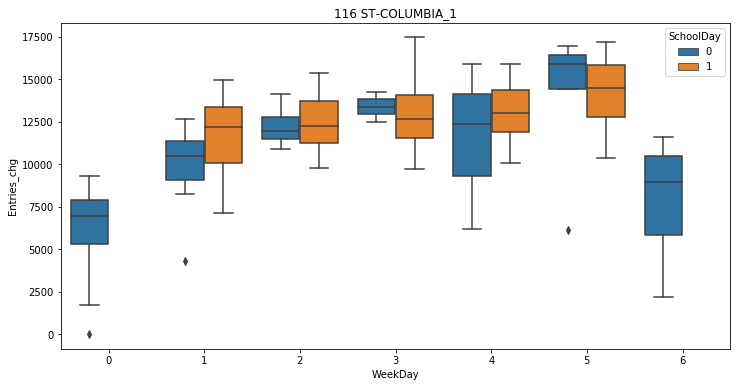

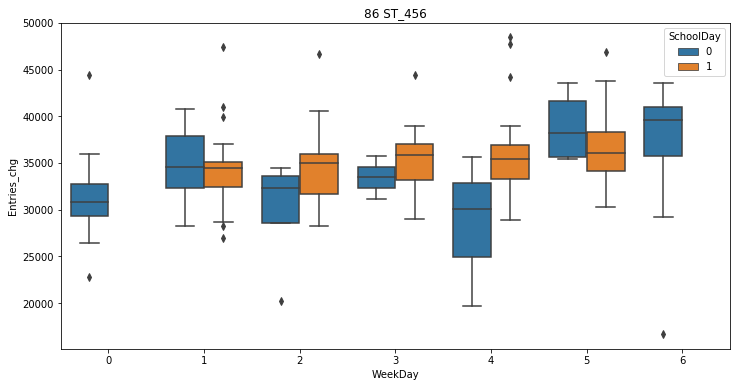

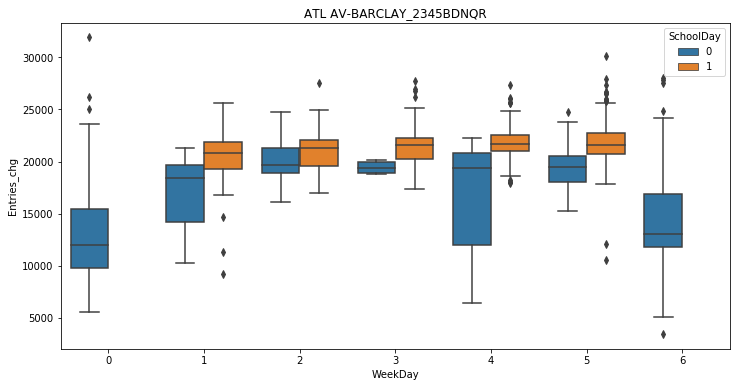

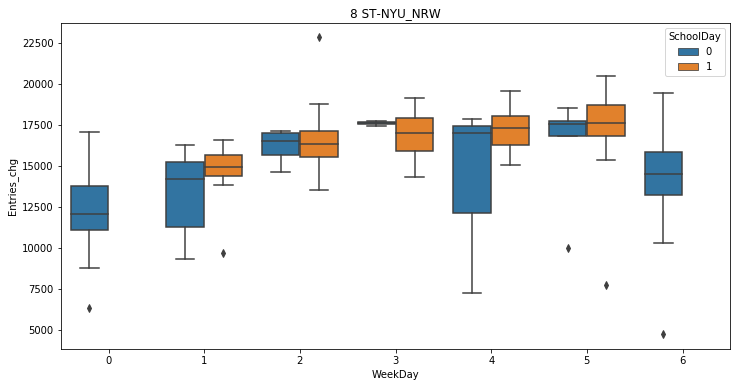

In [0]:
for stn in  [
             '116 ST-COLUMBIA_1',
             '86 ST_456',
             'ATL AV-BARCLAY_2345BDNQR',
             '8 ST-NYU_NRW']:	
    viz_aug_data(aug_train,figsz=(12,6),x='WeekDay',station=stn,hue='SchoolDay')    

### When the Brooklyn Nets play home games at `ATL AV-BARCLAY_2345BDNQR` we observe:
- Increased Entries at `ATL AV-BARCLAY_2345BDNQR` as expected,
- Neighboring stations `BERGEN ST_23`, `UNION_ST_R`, `GRAND ARMY PLAZ_23`, and `WALL ST_23` saw elevated ridership 

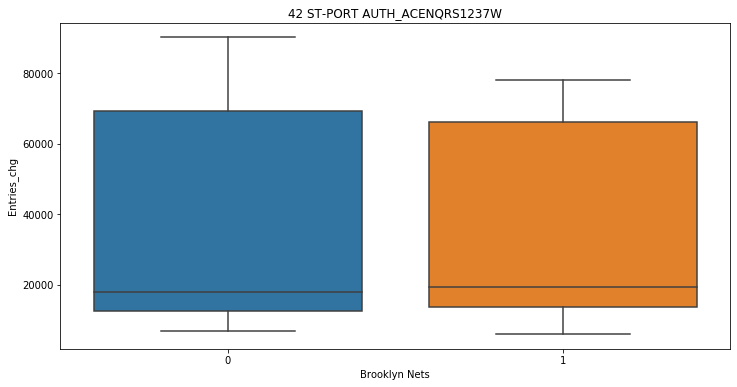

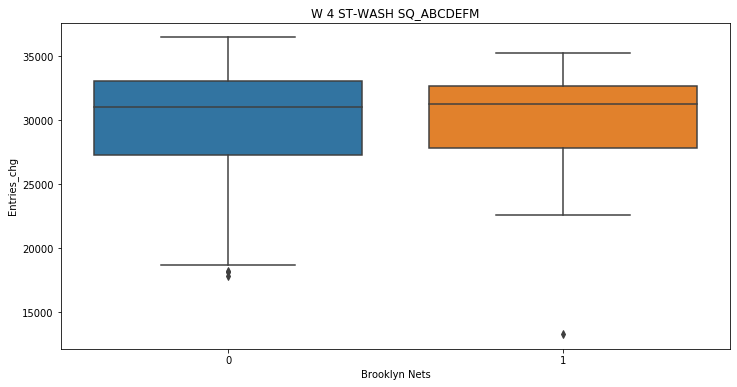

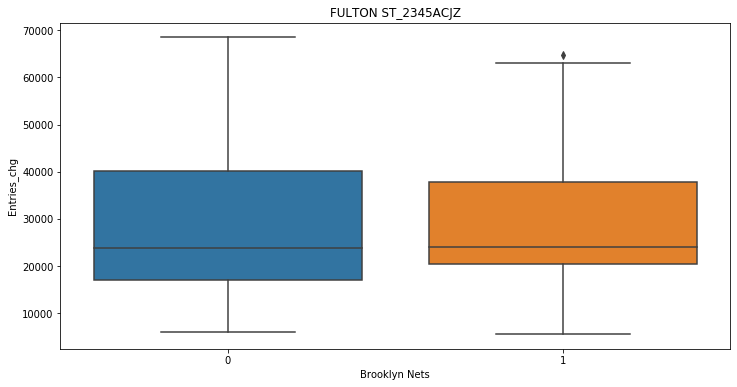

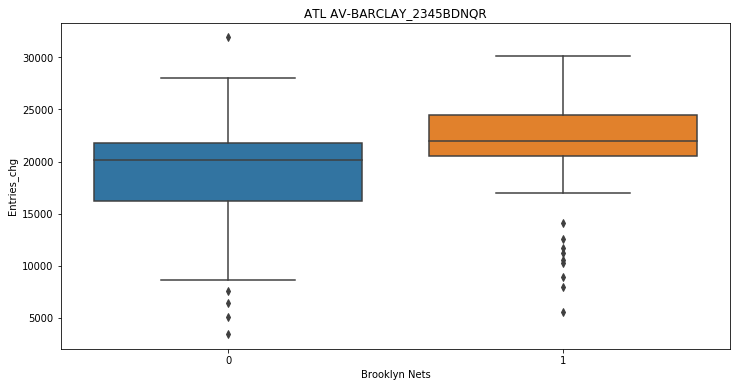

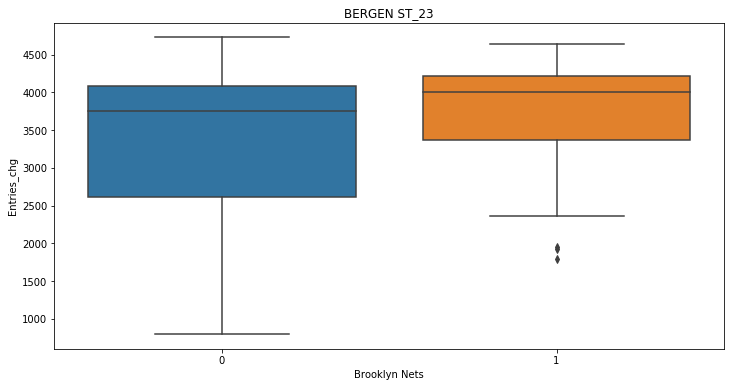

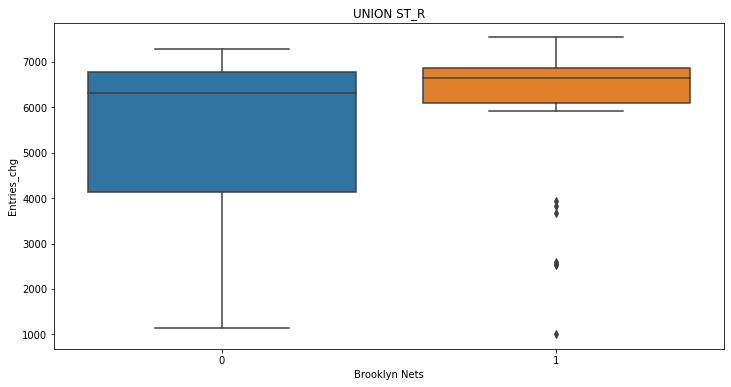

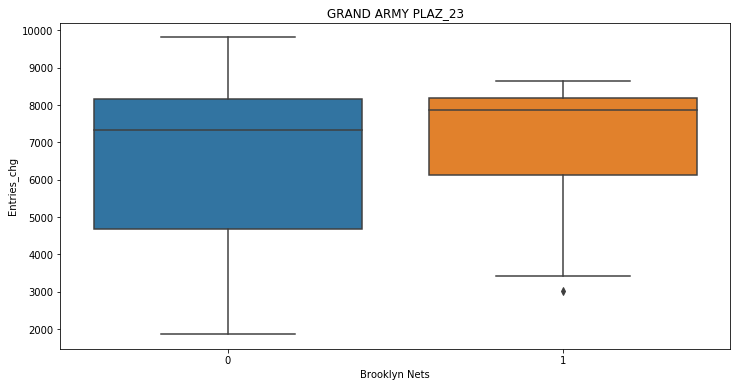

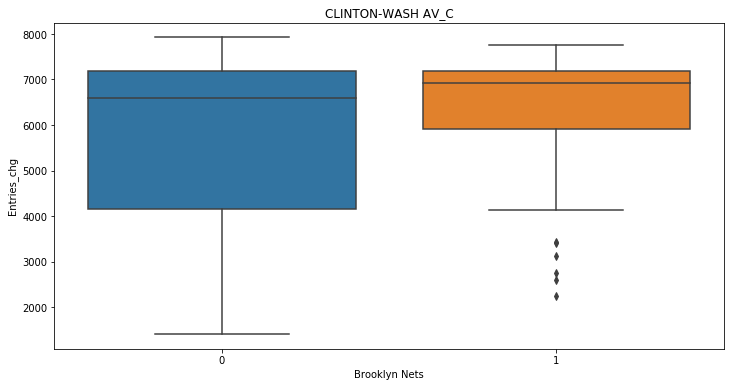

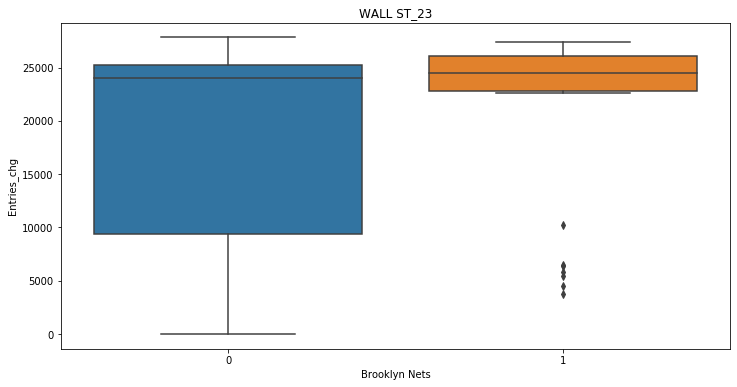

In [0]:
for stn in  [
             '42 ST-PORT AUTH_ACENQRS1237W',
             'W 4 ST-WASH SQ_ABCDEFM',
             'FULTON ST_2345ACJZ',
             'ATL AV-BARCLAY_2345BDNQR',
             'BERGEN ST_23',
             'UNION ST_R',
             'GRAND ARMY PLAZ_23',
             'CLINTON-WASH AV_C',
             'WALL ST_23'
             ]:	
    viz_aug_data(aug_train,figsz=(12,6),x='Brooklyn Nets',station=stn,hue=None)    

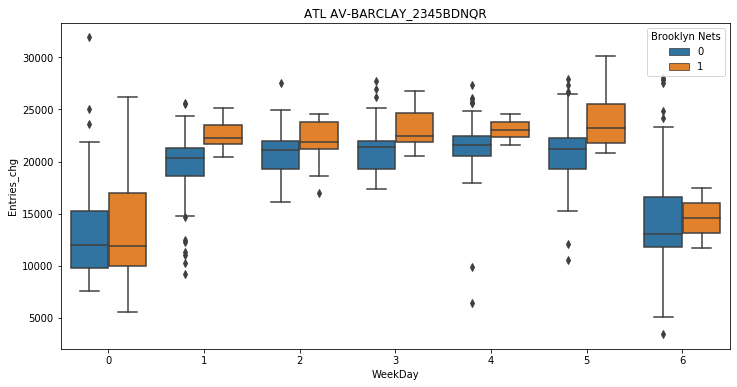

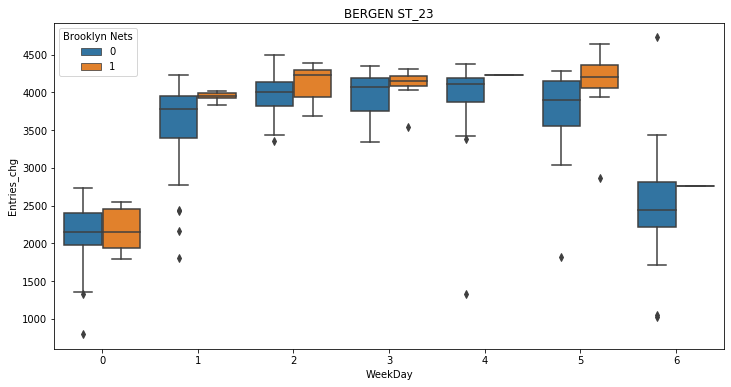

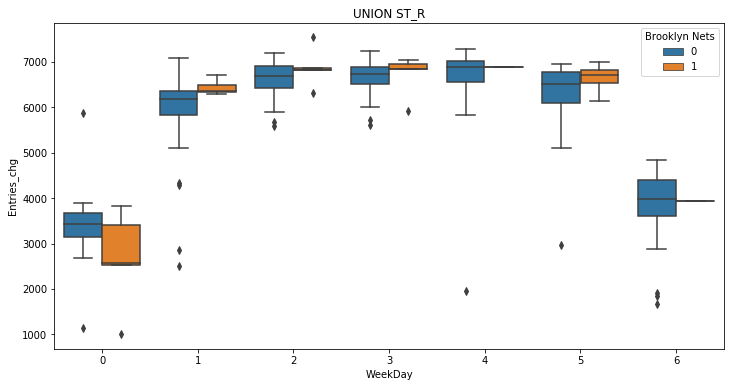

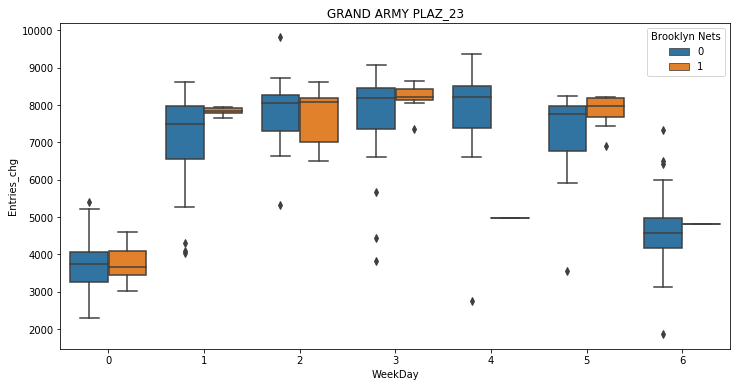

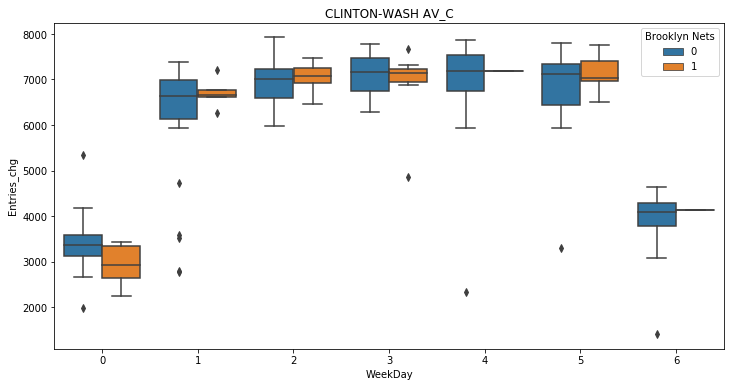

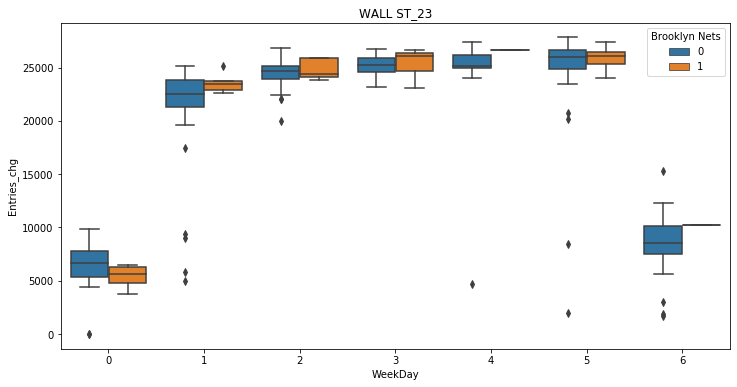

In [0]:
for stn in  [
             'ATL AV-BARCLAY_2345BDNQR',
             'BERGEN ST_23','UNION ST_R',
             'GRAND ARMY PLAZ_23',
             'CLINTON-WASH AV_C',
             'WALL ST_23',
            ]:	
    viz_aug_data(aug_train,figsz=(12,6),x='WeekDay',station=stn,hue='Brooklyn Nets')    

### View Football Effects

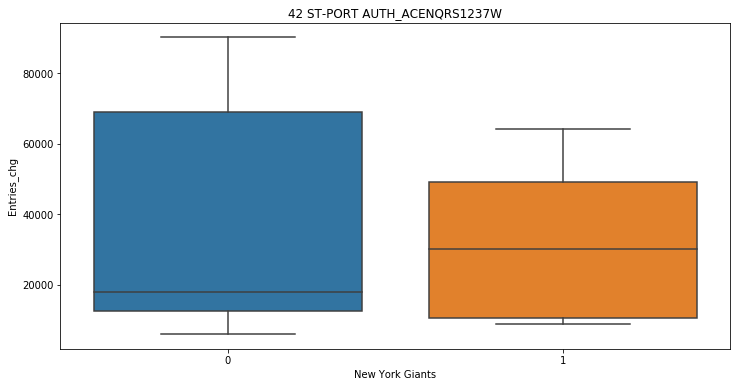

In [0]:
for stn in  [
             '42 ST-PORT AUTH_ACENQRS1237W',
             ]:	
    viz_aug_data(aug_train,figsz=(12,6),x='New York Giants',station=stn,hue=None)    

### View New York Jets Effects
 - Median ridership increases on Sunday game day at Port Authority

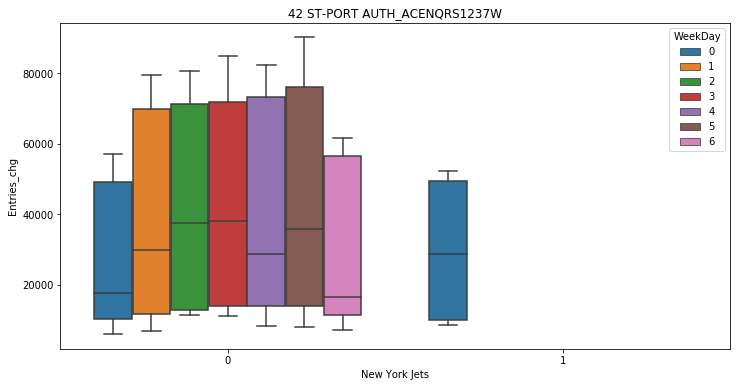

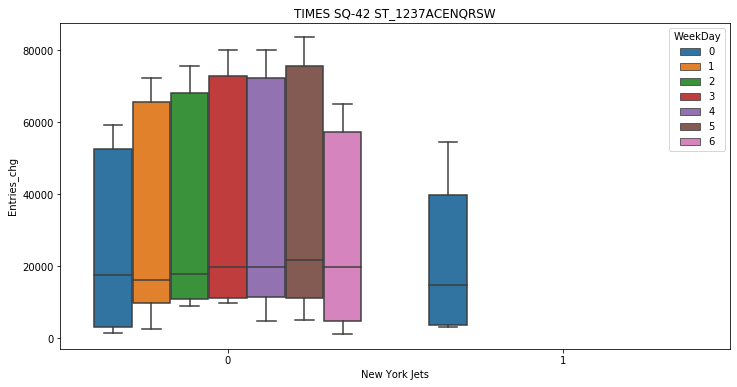

In [0]:
for stn in  [
             '42 ST-PORT AUTH_ACENQRS1237W',
             'TIMES SQ-42 ST_1237ACENQRSW',
             ]:	
    viz_aug_data(aug_train,figsz=(12,6),x='New York Jets',station=stn,hue='WeekDay')    

### View US Open Tennis Effects

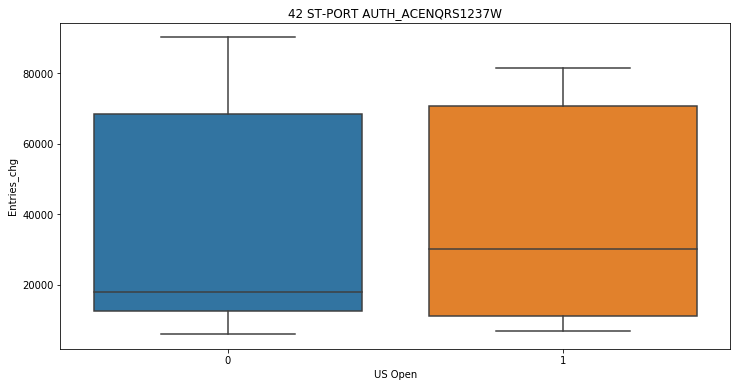

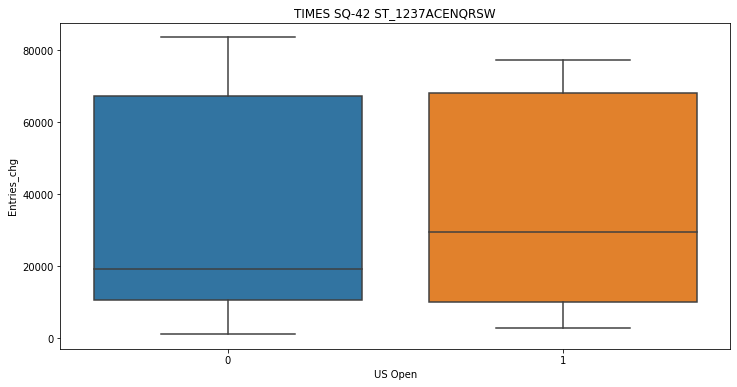

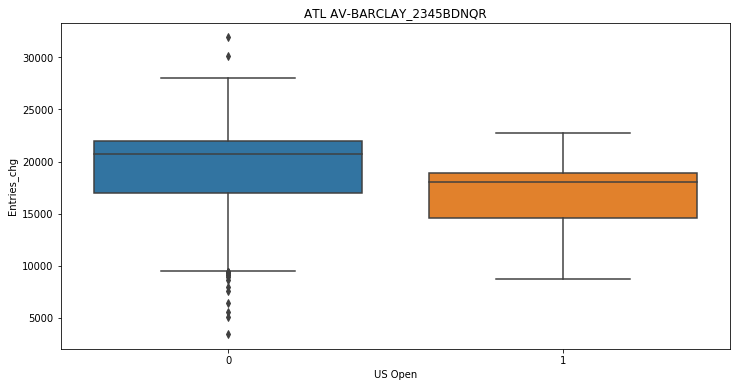

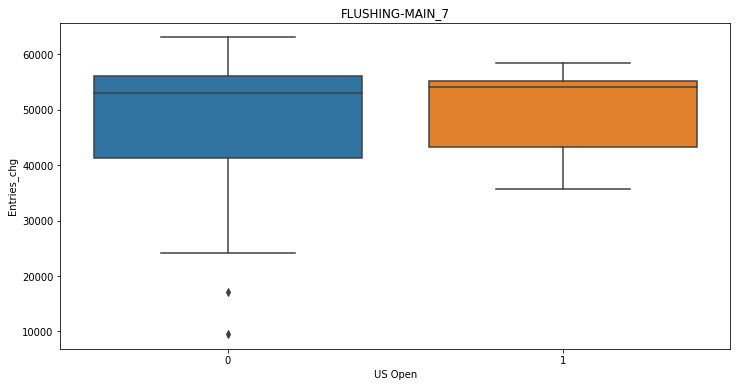

In [0]:
for stn in  [
             '42 ST-PORT AUTH_ACENQRS1237W',
             'TIMES SQ-42 ST_1237ACENQRSW',
             'ATL AV-BARCLAY_2345BDNQR',
             'FLUSHING-MAIN_7',
            ]:	
    viz_aug_data(aug_train,figsz=(12,6),x='US Open',station=stn,hue=None)    

### View Weather Effects on Ridership
- `freezing` exhibits mixed effects across stations.
- Ridership increased on Wednesdays and Fridays at `86 ST` during freezing temperatures (museum attendance increases on cold days?).
- But was lower for all week days at `CLARK ST_23`, which is a quiet bedroom neighborhood (Brooklyn Heights)  
- Fewer people went to the Aquarium between Coney Island and Brighton Beach when it was freezing.
- Cold weather also reduced visits to the Natural History Museum.   

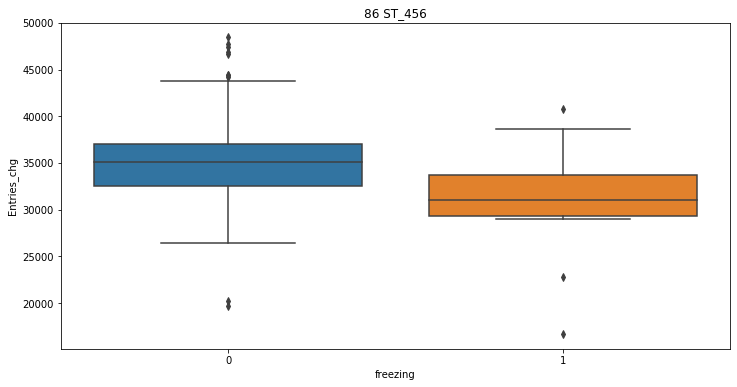

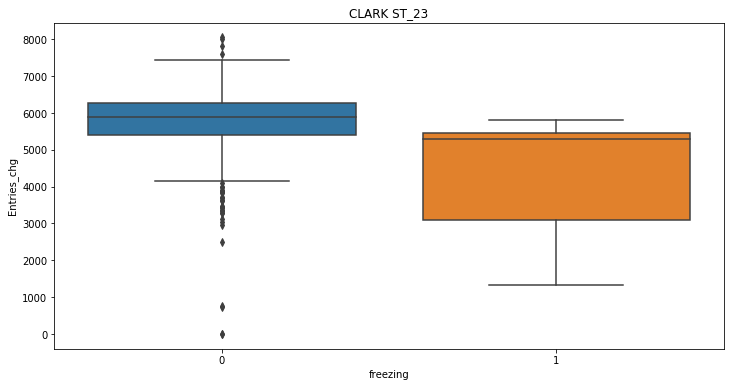

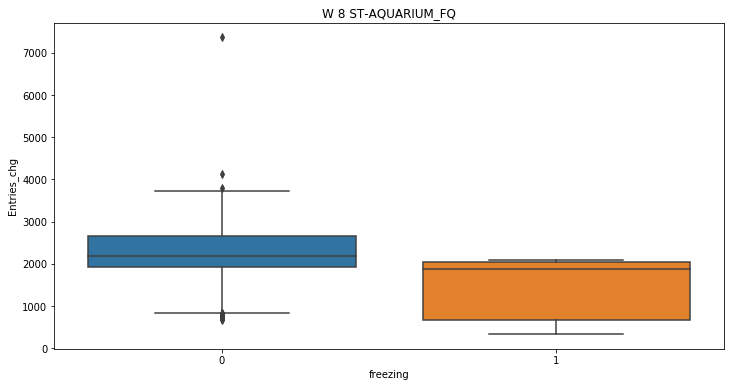

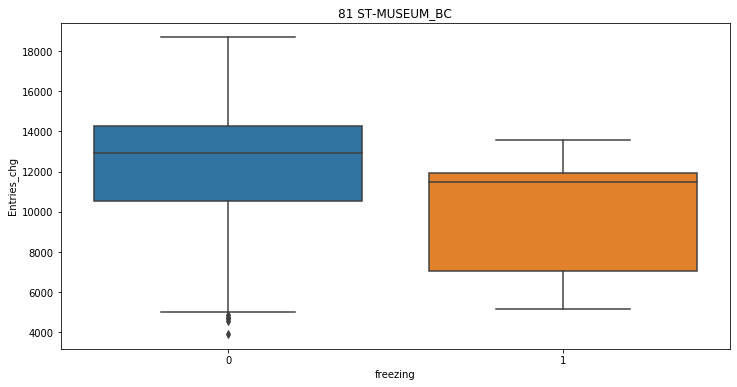

In [0]:
for stn in  [
             '86 ST_456',
             'CLARK ST_23',
             'W 8 ST-AQUARIUM_FQ',
             '81 ST-MUSEUM_BC'
            ]:	
    viz_aug_data(aug_train,figsz=(12,6),x='freezing',station=stn,hue=None)    

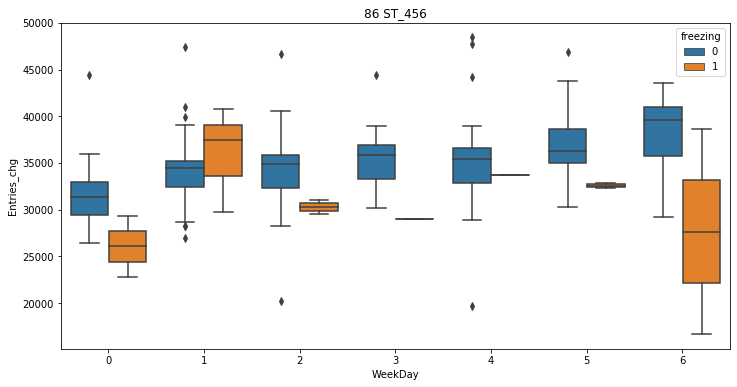

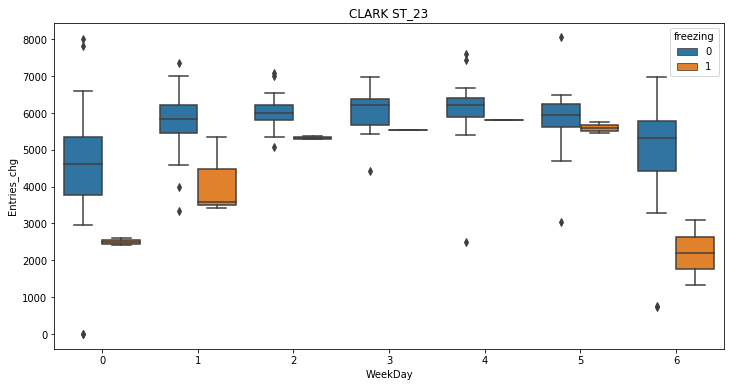

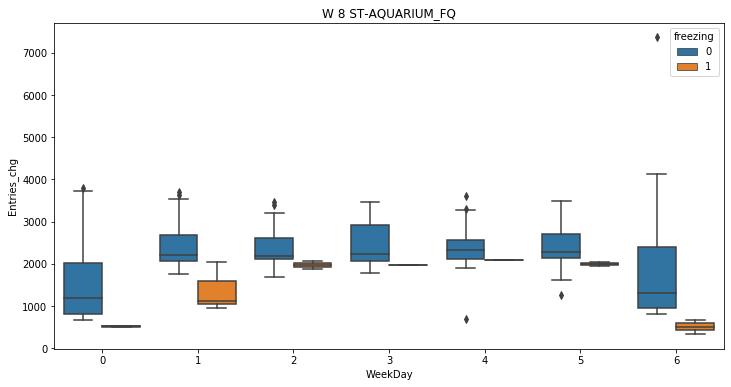

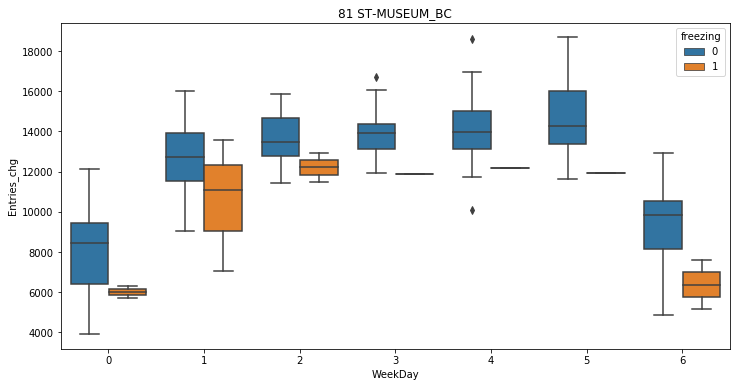

In [0]:
for stn in  [
             '86 ST_456',
             'CLARK ST_23',
             'W 8 ST-AQUARIUM_FQ',
             '81 ST-MUSEUM_BC'
            ]:	
    viz_aug_data(aug_train,figsz=(12,6),x='WeekDay',station=stn,hue='freezing')    

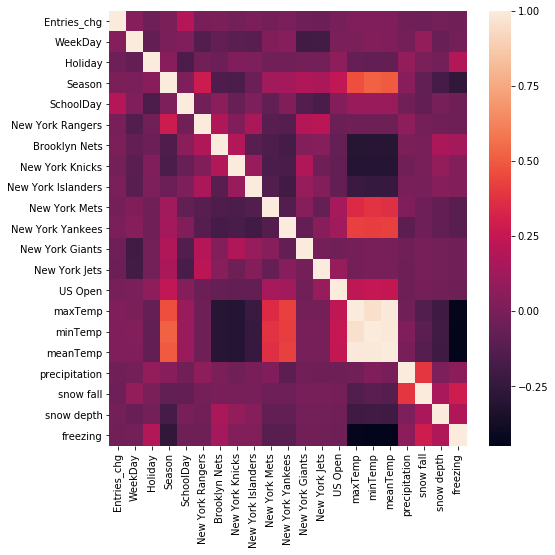

Target, Feature Correlations


Entries_chg
Entries_chg            1.000000
SchoolDay              0.191885
WeekDay                0.041053
maxTemp                0.019426
meanTemp               0.018335
minTemp                0.016758
Season                 0.007555
Brooklyn Nets          0.006750
New York Yankees       0.001221
New York Islanders    -0.001081
New York Rangers      -0.003644
US Open               -0.009500
New York Mets         -0.015122
snow depth            -0.021640
New York Knicks       -0.021901
precipitation         -0.024414
freezing              -0.030360
New York Giants       -0.036410
Holiday               -0.036913
snow fall             -0.037627
New York Jets         -0.046978

In [0]:
Data.eda_corr(aug_train,figsz=(8,8))    

### Obtain NYC OpenData Permitted Events Historical dataset
- To introduce additional signals around 2016 large scale events source: [NYC OpenData](https://data.cityofnewyork.us/City-Government/NYC-Permitted-Event-Information-Historical/bkfu-528j)   

### Process Feature Engineering on Augmented Dataset and Store train, test Datasets by `Station_Linename` to `aug_stations_train_test_dict` 

In [0]:
eng_grps = ['WeekDay','SchoolDay','New York Rangers',
            'New York Knicks','Brooklyn Nets','New York Islanders',
            'New York Mets','New York Yankees','New York Giants',
            'New York Jets','US Open','freezing']

aug_stations_train_test_dict = data.store_station_datasets(aug_df,
                                                       data.stations_name_list,
                                                       date0='01/01/2016',
                                                       date1='12/01/2016',
                                                       tgt_eng_grps=eng_grps)

aug_stations_train_test_dict



Station_Linename individual train, test datasets computed


OrderedDict([('1 AV_L', (           Date  ... Entries_chg_freezing_std
               0    01/02/2016  ...              1918.740443
               1    01/09/2016  ...              1918.740443
               2    01/16/2016  ...              1918.740443
               3    01/30/2016  ...              1918.740443
               4    02/06/2016  ...              1918.740443
               ..          ...  ...                      ...
               331  01/04/2016  ...              2116.507179
               332  01/13/2016  ...              2116.507179
               333  01/22/2016  ...              2116.507179
               334  02/15/2016  ...              2116.507179
               335  02/11/2016  ...              2116.507179
               
               [313 rows x 83 columns],
                          Date  ... Entries_chg_freezing_std
               16   12/24/2016  ...              1918.740443
               27   12/28/2016  ...              1918.740443
               29  

### Train all individual `Station_Linenames` in augmented dataset and store metrics `rmse`,`r2` and model `best_est` to  container `aug_station_results_d`


In [0]:
aug_station_results_d = Model.estimate_stations(aug_stations_train_test_dict,
                                                GradientBoostingRegressor(),
                                                param_dists=gb_params,iters=1,
                                                target='Entries_chg')
aug_station_results_d  

Training with default sklearn estimator hyperparameters:
Missing test data for CITY HALL_R
Missing test data for CORTLANDT ST_R
Missing test data for JUNIUS ST_3
Missing test data for ORCHARD BEACH_6
Missing test data for PATH NEW WTC_1
Missing test data for PATH WTC 2_1
Missing test data for PENNSYLVANIA AV_3
Missing test data for SUTTER AV-RUTLD_3
Total Runtime: 0.82


defaultdict(tuple,
            {'1 AV_L': [2827.533202211662,
              0.12634825134287508,
              GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                                        init=None, learning_rate=0.1, loss='ls', max_depth=3,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0, min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0, n_estimators=100,
                                        n_iter_no_change=None, presort='deprecated',
                                        random_state=None, subsample=1.0, tol=0.0001,
                                        validation_fraction=0.1, verbose=0, warm_start=False)],
             '103 ST-CORONA_7': [2300.6931469249203,
              0.3929294803092477,
              Gradient

### Augmented Features Results
- Problem 2 estimator with fewer features resulted in sum RMSE of `768,300` and mean `R2` score of `0.618462`, 
- Problem 3 estimator with augmented data resulted in sum RMSE of `723,200` and mean `R2` score of `0.659705`, a significant improvement over the previous result. 

----------------------------------------------------------------------
Individual Station Test Results:


sum Test RMSE:	723,190



RMSE          R2
count    457.000000  457.000000
mean    1582.473626    0.659705
std     2420.953600    0.305711
min       46.954688    0.000000
25%      435.224722    0.525290
50%      897.409685    0.766787
75%     1804.098782    0.909147
max    26283.555094    0.976777

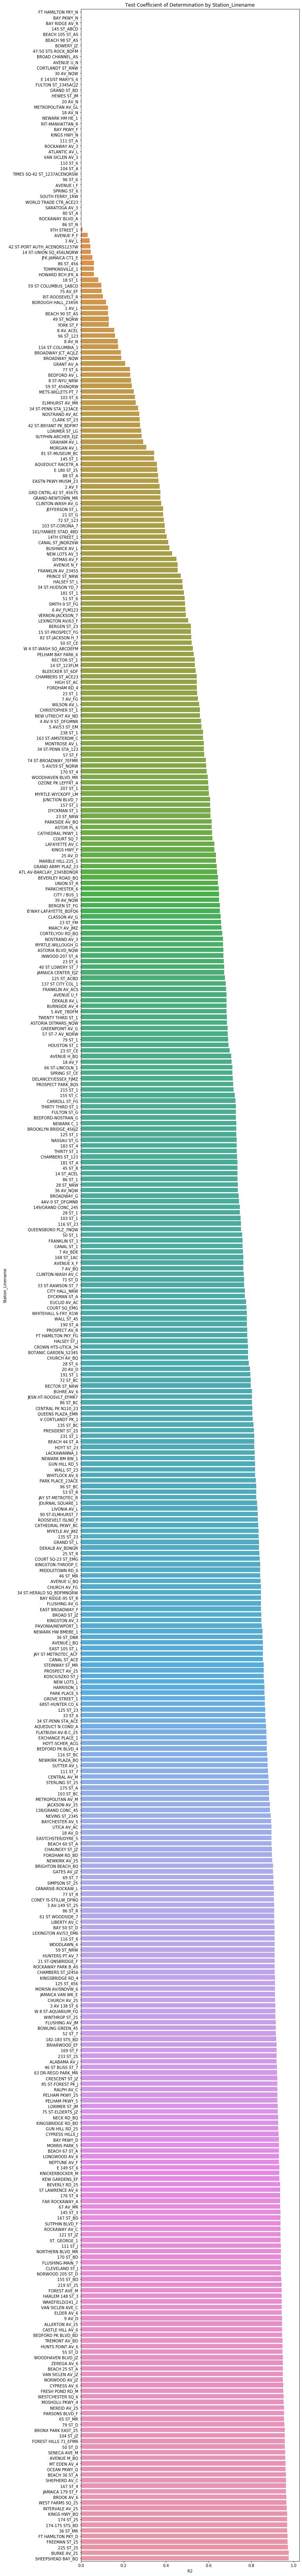

In [0]:
Model.station_estimator_results(aug_station_results_d) 

### Selected Feature Importances by `Station_Linename`
 - `Entries_chg_WeekDay` related target-statistical features continued to contribute the greatest decreases in node impurity when building decision trees.


Feature Importance Summary:


importance
feature                                      
Entries_chg_WeekDay_mean             0.327547
Entries_chg_WeekDay_max              0.244024
Entries_chg_WeekDay_min              0.175607
Entries_chg_WeekDay_med              0.055149
Holiday                              0.052915
...                                       ...
Entries_chg_New York Giants_med      0.000000
Entries_chg_New York Mets_mean       0.000000
New York Jets                        0.000000
Entries_chg_New York Mets_std        0.000000
Entries_chg_New York Rangers_mean    0.000000

[80 rows x 1 columns]

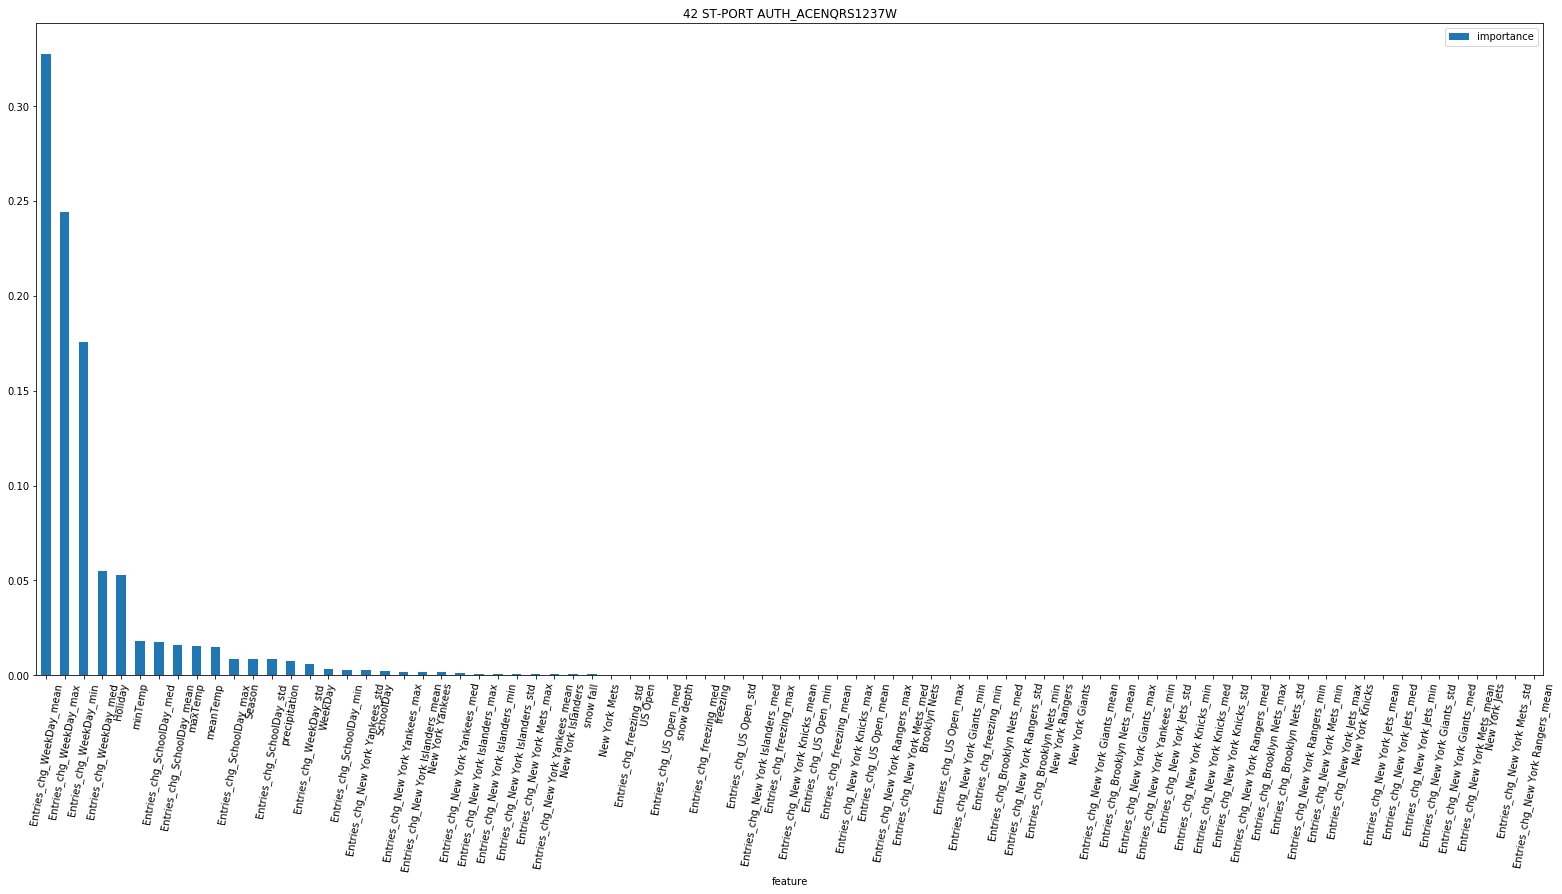

In [0]:
# st = '86 ST_456'
st = '42 ST-PORT AUTH_ACENQRS1237W'
X = aug_stations_train_test_dict[st][0].drop(['Date',
                                              'Entries_chg',
                                              'Station_Linename'],axis=1)
st_est = aug_station_results_d[st][2]
Model.estimator_feature_importances(st_est,X,figsz=(27,12),xrotate=80,
                                    show_df=True,station_name=st)


Feature Importance Summary:


importance
feature                                      
Entries_chg_WeekDay_mean             0.327547
Entries_chg_WeekDay_max              0.244024
Entries_chg_WeekDay_min              0.175607
Entries_chg_WeekDay_med              0.055149
Holiday                              0.052915
...                                       ...
Entries_chg_New York Giants_med      0.000000
Entries_chg_New York Mets_mean       0.000000
New York Jets                        0.000000
Entries_chg_New York Mets_std        0.000000
Entries_chg_New York Rangers_mean    0.000000

[80 rows x 1 columns]

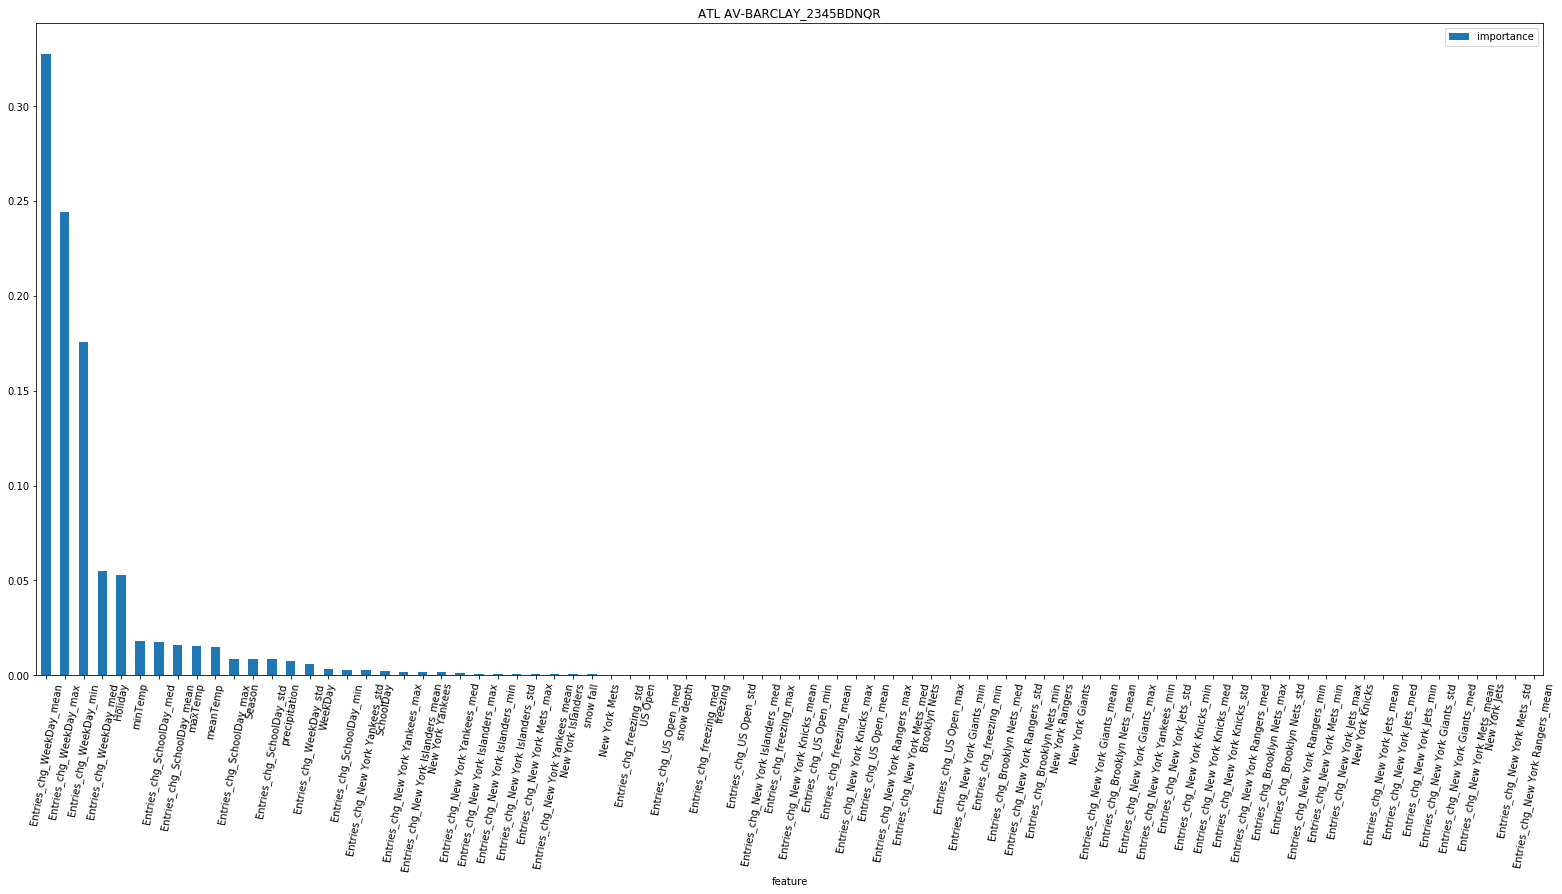

In [0]:
st = 'ATL AV-BARCLAY_2345BDNQR'
X = aug_stations_train_test_dict[st][0].drop(['Date','Entries_chg','Station_Linename'],axis=1)
st_est = aug_station_results_d[st][2]
Model.estimator_feature_importances(st_est,X,figsz=(27,12),xrotate=80,
                                    show_df=True,station_name=st)


Feature Importance Summary:


importance
feature                                      
Entries_chg_WeekDay_mean             0.327547
Entries_chg_WeekDay_max              0.244024
Entries_chg_WeekDay_min              0.175607
Entries_chg_WeekDay_med              0.055149
Holiday                              0.052915
...                                       ...
Entries_chg_New York Giants_med      0.000000
Entries_chg_New York Mets_mean       0.000000
New York Jets                        0.000000
Entries_chg_New York Mets_std        0.000000
Entries_chg_New York Rangers_mean    0.000000

[80 rows x 1 columns]

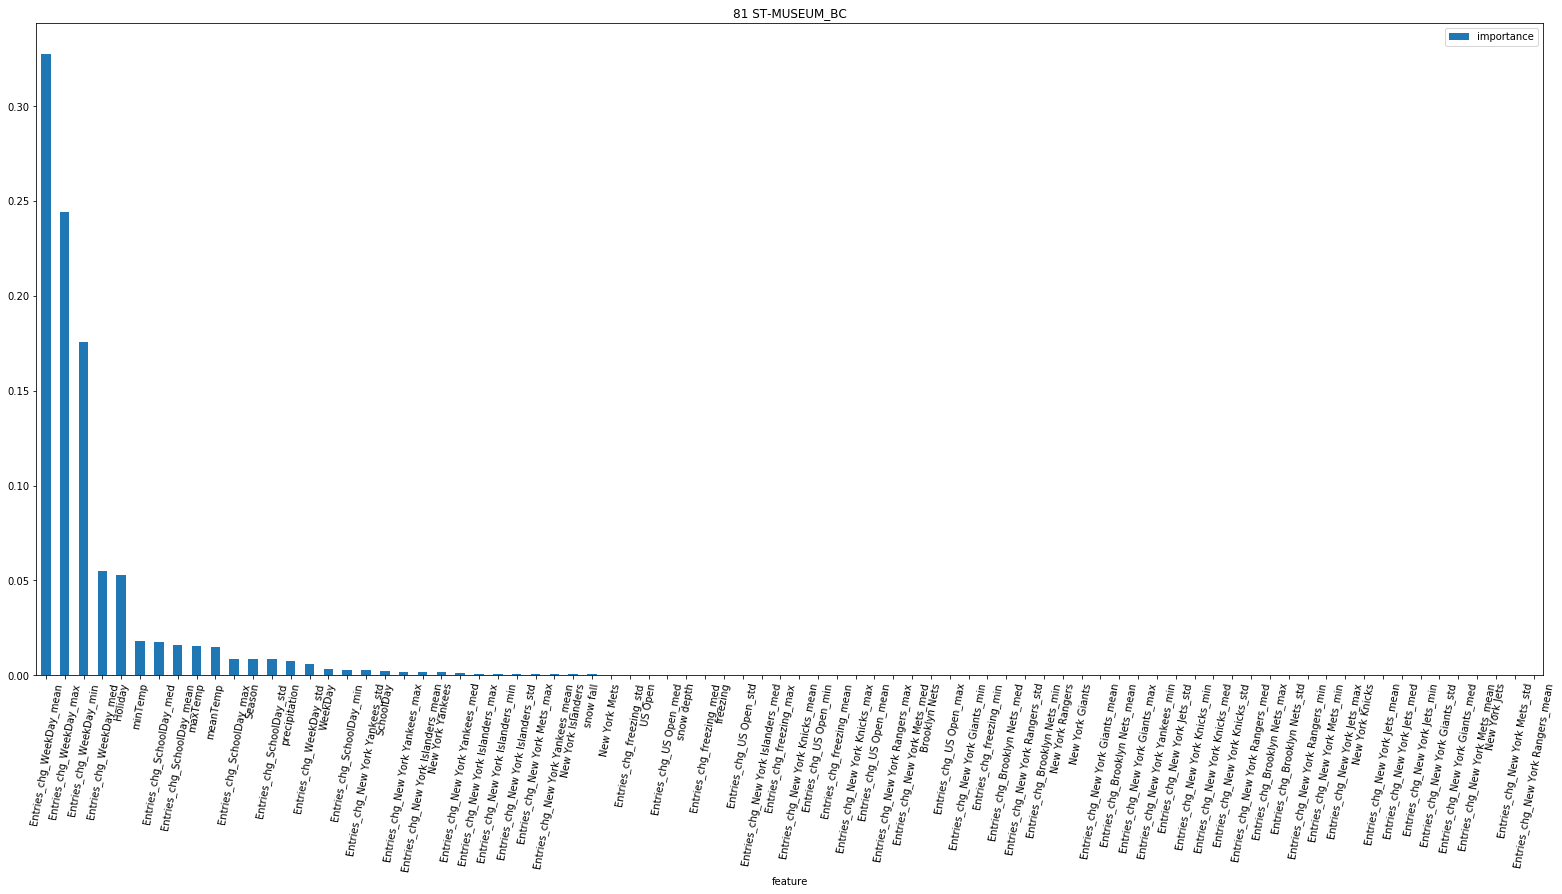

In [0]:
st = '81 ST-MUSEUM_BC' 
X = aug_stations_train_test_dict[st][0].drop(['Date','Entries_chg','Station_Linename'],axis=1)
st_est = aug_station_results_d[st][2]
Model.estimator_feature_importances(st_est,X,figsz=(27,12),xrotate=80,
                                    show_df=True,station_name=st)


Feature Importance Summary:


importance
feature                                      
Entries_chg_WeekDay_mean             0.327547
Entries_chg_WeekDay_max              0.244024
Entries_chg_WeekDay_min              0.175607
Entries_chg_WeekDay_med              0.055149
Holiday                              0.052915
...                                       ...
Entries_chg_New York Giants_med      0.000000
Entries_chg_New York Mets_mean       0.000000
New York Jets                        0.000000
Entries_chg_New York Mets_std        0.000000
Entries_chg_New York Rangers_mean    0.000000

[80 rows x 1 columns]

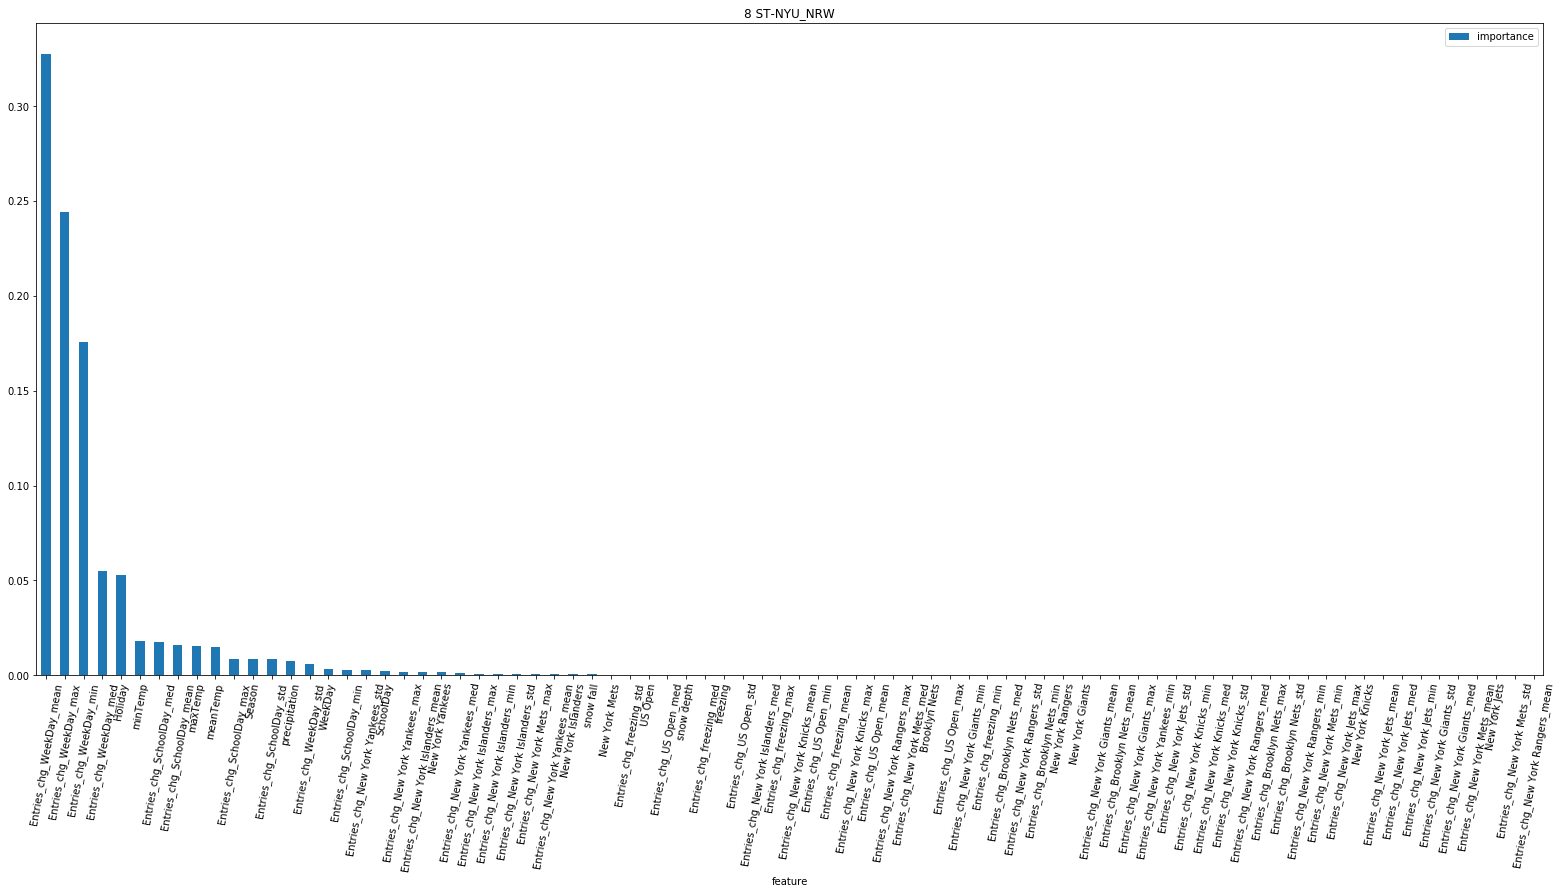

In [0]:
st = '8 ST-NYU_NRW'
X = aug_stations_train_test_dict[st][0].drop(['Date','Entries_chg',
                                              'Station_Linename'],axis=1)
st_est = aug_station_results_d[st][2]
Model.estimator_feature_importances(st_est,X,figsz=(27,12),xrotate=80,
                                    show_df=True,station_name=st)

### Conclusion: 
- Overall, ensemble tree regressors performed reasonably well with minimal feature engineering and hyperparameter tuning. 

- With further investment, we could brainstorm new sources to augment the dataset, especially related to specific events in NYC such as the ball drop in TIMES SQ 42 ST or any of the scheduled parades which would affect ridership at corresponding stations. 
